# Methods for Data Science: Course Work 1

## Task 1:  Regression (50 marks)



In [1]:
# import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

#### 1.1 Linear regression (8 marks)  

1.1.1

In this question we will train an unregularised linear regresion model on our training dataset using the analytic maximum likelihood parameter estimate, and then test it's performance on our testing dataset.

Our linear regression model is given for data $\boldsymbol x_i$ and $y_i$:
\begin{align}
y_i = \beta_0 + \boldsymbol x_i^T \boldsymbol \beta + \epsilon_i,\quad \epsilon \sim \mathcal{N}(0,\sigma^2), \quad i=1,\dots,n.
\end{align}

From now on we will denote $\boldsymbol X = \begin{bmatrix}\boldsymbol x_1^T \\ \vdots \\ \boldsymbol x_n^T \end{bmatrix}$, and so our model can also be expressed as:
\begin{align}
\boldsymbol y &= \boldsymbol 1\beta_0 + \boldsymbol X \boldsymbol \beta + \boldsymbol \epsilon, \quad \epsilon \sim \mathcal{N}(0, \boldsymbol I \sigma^2), \quad i=1,\dots,n \\
\iff \boldsymbol y &= \boldsymbol X_{aug} \boldsymbol \beta_{aug} + \boldsymbol \epsilon, \quad \text{where $\boldsymbol X_{aug} = \begin{bmatrix}\boldsymbol 1 & \boldsymbol X\end{bmatrix}$, and $\boldsymbol\beta_{aug} = \begin{bmatrix} \beta_0 \\ \boldsymbol\beta \end{bmatrix}$}.
\end{align}

Throughout the coursework we will use $\boldsymbol 1$ to represent a column vector of ones.

We would first like to obtain a linear regression model with target variable 'Sound Pressure', trained using the airfoil noise dataset. Below we read in this training data into using pandas.

In [2]:
# load training data as pandas data frames
airfoil_data = pd.read_csv('./airfoil_noise_samples.csv')
# print shape and last 5 rows
print(airfoil_data.shape)
airfoil_data.tail()

(3890, 7)


Frequency     Angle  Displacement  Chord length   Velocity  Thickness  \
3885  3905.607276  9.799786     11.765429      0.028704  67.798053   0.004488   
3886    64.227331  2.707020     14.811376      0.235426  31.178047   0.001760   
3887  3284.747651  0.569689      0.340812      0.040439  49.229545   0.002682   
3888  5335.315242  5.525639     15.952651      0.197330  31.902680   0.008405   
3889  1334.882117  8.276053     14.560548      0.134638  63.902501   0.023547   

      Sound Pressure  
3885      125.085653  
3886      123.172927  
3887      134.214100  
3888      116.550551  
3889      123.960690

Let us check that our training data is clean and numeric.

In [3]:
print(f"Total null values = {airfoil_data.isnull().sum().sum()}")
print(f"Total repeated values = {airfoil_data.duplicated().sum()}")
print(f"Dataframe types = {airfoil_data.dtypes}")

Total null values = 0
Total repeated values = 0
Dataframe types = Frequency         float64
Angle             float64
Displacement      float64
Chord length      float64
Velocity          float64
Thickness         float64
Sound Pressure    float64
dtype: object


We have no null values, no repeated values, and also all of our predictors are numeric (float64).

We see that our target variable is in the final column of our dataframe, so now we split the outcomes from the predictors.

In [4]:
# put outcome and predictors in different dataframes
y_train = airfoil_data.loc[:, "Sound Pressure"]
X_train = airfoil_data.iloc[:, :-1]

# check the split was done correctly
print(y_train.tail())
print(X_train.tail())

# convert to numpy arrays
y_train = y_train.to_numpy()
X_train = X_train.to_numpy()

3885    125.085653
3886    123.172927
3887    134.214100
3888    116.550551
3889    123.960690
Name: Sound Pressure, dtype: float64
        Frequency     Angle  Displacement  Chord length   Velocity  Thickness
3885  3905.607276  9.799786     11.765429      0.028704  67.798053   0.004488
3886    64.227331  2.707020     14.811376      0.235426  31.178047   0.001760
3887  3284.747651  0.569689      0.340812      0.040439  49.229545   0.002682
3888  5335.315242  5.525639     15.952651      0.197330  31.902680   0.008405
3889  1334.882117  8.276053     14.560548      0.134638  63.902501   0.023547


Notice that our features are over different ranges, and so it is appropriate to work with standardised data in our linear regression model so that all the predictors are on the same scale.

Below we standardise our training data, storing the mean and standard deviation of each column in memory so we can later transform the testing data by the same transformation.

In [5]:
# standardise our training data by calculating the mean and standard deviations of the columns
mu_train = np.mean(X_train, 0)
sigma_train = np.std(X_train, 0)
X_train_std = (X_train - mu_train)/sigma_train

To train the model on the data we must optimise our loss function, given by $L(\boldsymbol\beta) = \frac{1}{2N}\|\boldsymbol y - \boldsymbol X \boldsymbol\beta - \boldsymbol 1\beta_0\|^2$ over the space of $\boldsymbol\beta$.
\begin{align}
\underset{\boldsymbol\beta}{\text{min}} \frac{1}{2N}\| \boldsymbol y - \boldsymbol X \boldsymbol\beta \ - \boldsymbol 1\beta_0|^2 \iff \underset{\boldsymbol\beta}{\text{min}}\| \boldsymbol y - \boldsymbol X \boldsymbol\beta \ - \boldsymbol 1\beta_0|^2
\iff \underset{\boldsymbol\beta}{\text{min}}\| \boldsymbol y - \boldsymbol X_{aug} \boldsymbol\beta_{aug} \|^2, \\ \text{where $\boldsymbol X_{aug} = \begin{bmatrix}\boldsymbol 1 & \boldsymbol X\end{bmatrix}$, and $\boldsymbol\beta_{aug} = \begin{bmatrix} \beta_0 \\ \boldsymbol\beta \end{bmatrix}$}.
\end{align}

From the lectures we know that the maximum likelihood estimator is given by:

\begin{align} \boldsymbol\beta_{aug}^{ML} = (\boldsymbol X_{aug}^T\boldsymbol X_{aug})^{-1}\boldsymbol X_{aug}^T\boldsymbol y.\end{align}

We can make predictions corresponding to another given predictor matrix $X_{aug}^\prime$ using this $\boldsymbol \beta_{aug}^{ML}$:
\begin{align} \boldsymbol y_{pred} = \boldsymbol X_{aug}^\prime\boldsymbol\beta_{aug}^{ML}.
\end{align}

Let us define some functions: `max_lik_estimate_aug` helps to compute the maximum likelihood estimate for the training dataset, and `predict_with_estimate` makes an outcome prediction as defined above.

In [6]:
def max_lik_estimate_aug(X_aug, y):
    """
    Calculates the maximum likelihood estimator for our linear regression parameters.
    Args:
    X_aug: Augmented predictor data of size (n, d+1), where d is the number of predictors.
    y: outcome data of size (n, 1).
    
    Returns:
    beta_aug_ml: parameter prediction of size (d+1, 1).
    """
    beta_aug_ml = np.linalg.solve(X_aug.T @ X_aug, X_aug.T @ y)
    
    return beta_aug_ml

In [7]:
def predict_with_estimate(X_test, beta):
    """
    Predicts outcome using augmented data matrix and parameters.
    Args:
    X_test: Augmented test predictor data of size (k, d+1), where d is the number of predictors.
    beta: parameter prediction of size (d+1, 1).
    
    Returns:
    prediction: outcome prediction of size (k, 1).
    """

    prediction = X_test @ beta
    
    return prediction 

We augment our training data now with a column of ones so that it is of appropriate form for our functions, and then call `max_lik_estimate_aug` to obtain the maximum likelihood estimator of the intercept and parameters in our trained linear regression model.

In [8]:
# augmented training inputs with column of 1s
X_train_std_aug = np.hstack([np.ones((X_train_std.shape[0],1)), X_train_std])

# estimate beta using our training data
beta_aug_ml = max_lik_estimate_aug(X_train_std_aug, y_train)
print("inferred values of beta:", beta_aug_ml)

inferred values of beta: [ 1.23970283e+02 -3.57549693e+00  8.34478004e-01 -3.92864721e+00
 -7.83341979e-02  1.72495668e+00 -1.35633979e-02]


Our next step is to quantify how good our linear regression model is. Mean squared error and $R^2$ score (coefficient of determination) are common ways of scoring the model. Below we define functions `ms_error` and `r2_score` that are helpful in calculating mean squared error as well as $R^2$ score, and we will use these to get statistics for all of our regression models.

In [9]:
def ms_error(y_test, y_pred):
    """
    Calculate the mean squared error between actual and predicted outcomes.
    Args:
    y_test: true outcome data of size (k, 1).
    y_pred: outcome prediction of size (k, 1).
    
    Returns:
    ms_error: float, the mean squared error of our prediction.
    """
    ms_error = 1/(len(y_pred)) * np.sum(np.square(y_test - y_pred))
    return ms_error

In [10]:
def r2_score(y_test, y_pred):
    """
    Calculate the R^2 score between actual and predicted outcomes.
    Args:
    y_test: true outcome data of size (k, 1).
    y_pred: outcome prediction of size (k, 1).
    
    Returns:
    r2_score: float, the R^2 score of our prediction.
    """
    numerator = np.sum(np.square(y_test - y_pred))
    y_avg = np.mean(y_test)
    denominator = np.sum(np.square(y_test - y_avg))
    r2_score = 1 - numerator/denominator
    return r2_score

We now report the in-sample (i.e. pass in our training prediction) mean squared errors and $R^2$ score.

In [11]:
# use our beta estimate to make predictions on our training data
y_train_pred = predict_with_estimate(X_train_std_aug, beta_aug_ml)
# calculate metrics and print
linreg_train_mse = ms_error(y_train, y_train_pred)
linreg_train_r2 = r2_score(y_train, y_train_pred)
print("training set mean squared error:", linreg_train_mse)
print("training set R2 score:", linreg_train_r2)

training set mean squared error: 1.8755566396402024
training set R2 score: 0.9177343977263076


1.1.2

We now apply our trained linear regression model to try and predict the target variable 'Sound Pressure' using our predictors in the test noise dataset.

Let us read in the test data this time and split the outcome data from the predictor data.

In [12]:
# load data as pandas data frames
airfoil_data_test = pd.read_csv('./airfoil_noise_test.csv')

# print shape and last 5 rows
print(airfoil_data_test.shape)
airfoil_data_test.tail()

(973, 7)


Frequency      Angle  Displacement  Chord length   Velocity  Thickness  \
968   661.642089  16.204397     17.346930      0.033384  72.142746   0.005794   
969   670.716708   2.445070     11.610920      0.248936  24.644222   0.002454   
970  1332.771483  11.083461     15.955273      0.104500  68.543729   0.008514   
971  2718.763522   2.928932      3.939470      0.133589  73.328072   0.000757   
972  1959.014904  10.730063     14.775275      0.127446  47.155652   0.009146   

     Sound Pressure  
968      126.250349  
969      122.612541  
970      125.849598  
971      134.637862  
972      123.578108

Let us verify the testing data is clean and numeric.

In [13]:
print(f"Total null values = {airfoil_data_test.isnull().sum().sum()}")
print(f"Total repeated values = {airfoil_data_test.duplicated().sum()}")
print(f"Dataframe types = {airfoil_data_test.dtypes}")

Total null values = 0
Total repeated values = 0
Dataframe types = Frequency         float64
Angle             float64
Displacement      float64
Chord length      float64
Velocity          float64
Thickness         float64
Sound Pressure    float64
dtype: object


In [14]:
# put outcome and predictors in different dataframes
y_test = airfoil_data_test.loc[:, "Sound Pressure"]
X_test = airfoil_data_test.iloc[:, :-1]

# check the split was done correctly
print(y_test.tail())
print(X_test.tail())

# convert to numpy arrays
y_test = y_test.to_numpy()
X_test = X_test.to_numpy()

968    126.250349
969    122.612541
970    125.849598
971    134.637862
972    123.578108
Name: Sound Pressure, dtype: float64
       Frequency      Angle  Displacement  Chord length   Velocity  Thickness
968   661.642089  16.204397     17.346930      0.033384  72.142746   0.005794
969   670.716708   2.445070     11.610920      0.248936  24.644222   0.002454
970  1332.771483  11.083461     15.955273      0.104500  68.543729   0.008514
971  2718.763522   2.928932      3.939470      0.133589  73.328072   0.000757
972  1959.014904  10.730063     14.775275      0.127446  47.155652   0.009146


Since our linear regression model was trained using standardised data, it makes sense to transform the test data by the same transformation before making predictions using our model. We also augment the test data with the column of ones as the intercept term of our linear regression is stored in our maximum likelihood estimate of the parameters.

In [15]:
# standardise our testing data using the mean and standard deviation of our train data
X_test_std = (X_test - mu_train) / sigma_train

# augmented training inputs with column of 1s
X_test_std_aug = np.hstack([np.ones((X_test_std.shape[0],1)), X_test_std])

# use our beta estimate to make predictions on our test data
y_test_pred = predict_with_estimate(X_test_std_aug, beta_aug_ml)

We can now report the out-of-sample (i.e. pass in our test prediction) mean squared errors and $R^2$ score.

In [16]:
# calculate metrics and print
linreg_test_mse = ms_error(y_test, y_test_pred)
linreg_test_r2 = r2_score(y_test, y_test_pred)
print("testing set mean squared error:", linreg_test_mse)
print("testing set R2 score:", linreg_test_r2)

testing set mean squared error: 1.98438957711916
testing set R2 score: 0.9083172459581622


In [17]:
# create table summarising the in-sample and out-of-sample scores 
linreg_comparison_columns = ["train MSE", "test MSE", "train R2 score", "test R2 score"]
linreg_indexes = ["standard linear reg"]
linreg_comparison_array = np.array([linreg_train_mse, linreg_test_mse, linreg_train_r2, linreg_test_r2]).reshape((1, 4))
linreg_comparison_df = pd.DataFrame(linreg_comparison_array, columns=linreg_comparison_columns, index=linreg_indexes)
linreg_comparison_df

train MSE  test MSE  train R2 score  test R2 score
standard linear reg   1.875557   1.98439        0.917734       0.908317

Our findings show that the mean squared error when applying our trained linear regression model to the training data is less than when applying it to the test data. This is not surprising, since our training data was used to generate the inferred parameters of the model, and so intuitively it willhave less error than when predicting on the test data. Lower MSE is more desirable in general.

Also, our $R^2$ score is higher for our training predictions compared to our test predictions. $R^2$ score is a measure of how well our linear regression model predicts the variance in the outcomes data, and so similarly to MSE, our linear regression model performs better on the training data. Like MSE, it is better at predicting variance on the data that trained it rather than new test data. Higher $R^2$ score is more desirable in general.

We do see slightly worse performance between the model on the test data compared to the training data with respect to both metrics, which suggests that the model is fairly good, but does suffer from some slight overfitting/bias on training data.

#### 1.2 Lasso regression (12 marks) 

1.2.1

In this question, we will train a linear regression model with a Lasso regulariser using a gradient descent method. We will try and use 5-fold cross-validation to find the optimal penalty hyper-parameter $\lambda$, and explore how this hyper-parameter affects our inferred parameters.

This time for Lasso regression we will consider a different loss function to standard linear regression.

Our loss function is given by $L_{LASSO}(\boldsymbol\beta) = \frac{1}{2N}\|\boldsymbol y - \boldsymbol X \boldsymbol\beta - \boldsymbol 1 \beta_0\|^2 + \lambda \|\boldsymbol\beta\|_1$, which we will aim to minimise via gradient descent.

The 1-norm is convex, and so is the residual sum of squares term, which means that our loss function is convex and therefore has a unique global minimum which we should converge to by iteratively moving in the opposite direction of the gradient i.e. via gradient descent.

We implement the loss function below in `loss_func_lasso`.

In [18]:
def loss_func_lasso(X, y, beta, penalty):
    """
    Evaluate the loss function for lasso regression.
    Args:
    X: Augmented predictor data of size (n, d+1), where d is the number of predictors.
    y: outcome data of size (n, 1)
    beta: parameter prediction of size (d+1, 1).
    penalty: float, lasso penalty hyper-parameter lambda
    
    Returns:
    Loss, a float
    """
    n, d = X.shape
    return (1/(2*n)) * np.inner(y - X @ beta, y - X @ beta) + penalty * np.sum(np.abs(beta))

Essential to the gradient descent method is the gradient of the loss function itself, which we will now derive.

Let us write the loss function as:
$L_{Lasso} = \frac{1}{2N} \sum_{i=1}^N \left(y_i - \sum_{j=1}^p X_{ij}\beta_j - \beta_0\right)^2 + \lambda \sum_{i=1}^N |\beta_i|$.

We derive our gradient of the above loss function as follows:
For $k=1, \dots, n$:
\begin{align}
\frac{\partial L_{Lasso}}{\partial \beta_k} &= \frac{1}{2N} \cdot 2 \cdot\sum_{i=1}^N \left(y_i - \sum_{j=1}^p X_{ij}\beta_j - \beta_0\right)(-X_{ik}) + \lambda \rm sgn(\beta_k)\\
&= -\frac{1}{N}\sum_{i=1}^N X^{T}_{ki}\left(y_i - \sum_{j=1}^pX_{ij}\beta_j-\beta_0\right) + \lambda \rm sgn(\beta_k)\\
&= \left(-\frac{1}{N}\boldsymbol X^T\left(\boldsymbol y- \boldsymbol X_{aug}\beta_{aug}\right) + \lambda \rm sgn(\boldsymbol \beta)\right)_k\\
\implies \frac{\partial L_{Lasso}}{\partial \boldsymbol \beta}&= -\frac{1}{N}\boldsymbol X^T\left(\boldsymbol y- \boldsymbol X_{aug}\beta_{aug}\right) + \lambda \rm sgn(\boldsymbol \beta)
\end{align}

Now for $k=0$:
\begin{align}
\frac{\partial L_{Lasso}}{\partial \beta_0} &= \frac{1}{2N} \cdot 2 \cdot\sum_{i=1}^N \left(y_i - \sum_{j=1}^p X_{ij}\beta_j - \beta_0\right)(-1)\\
&= -\frac{1}{N}\sum_{i=1}^N \left(\boldsymbol y - \boldsymbol X_{aug}\boldsymbol \beta_{aug} \right)_i
\end{align}

Although the Lasso term is non-differentiable at 0, we can interpolate and assign it the value 0 in our gradient, which is also the convention used by the `numpy.sign` function.

Below we define `get_grad_lasso` to help calculate the gradient of our loss function, and also `gradient_descent_lasso` to execute the gradient descent algorithm. We need to update the terms like so:

\begin{align}
\boldsymbol \beta &= \boldsymbol \beta - \alpha \frac{\partial L_{LASSO}}{\partial \boldsymbol \beta},\\
\beta_0 &= \beta_0 - \alpha \frac{\partial L_{LASSO}}{\partial \beta_0}, \quad \alpha = \text{learning rate}.
\end{align}

Note that in our implementation, we work with augmented data matrices as defined previously in the linear regression question (column of ones on the left), and so we perform our gradient descent with the $\beta_0$ augmented to the top of our $\boldsymbol \beta$ in our code. We ensure that we set the derivative of $\beta_0$ appropriately as the first entry within `get_grad_lasso`.

In [19]:
def get_grad_lasso(X, y, beta, penalty):
    """
    Get gradient of lasso according to derived formulas.
    Arguments:
    X: Augmented predictor data of size (n, d+1), where d is the number of predictors.
    y: outcome data of size (n, 1).
    beta: intercept and parameters, a numpy array of size (d+1, 1).
    penalty: float, lasso penalty hyper-parameter lambda.
    
    Returns:
    dbeta: gradient of the loss with respect to beta.
    """
    n = X.shape[0]
    dbeta = -(1/n) * (X.T @ (y - (X @ beta))) + penalty * np.sign(beta)
    # overwrite dbeta_0 entry with correct derivative
    dbeta[0] = -(1/n) * np.sum(y - X @ beta) 
    
    return dbeta

In `gradient_descent_lasso`, we have selected our learing rate = $\frac{10}{N_{iterations}} \propto \frac{1}{N_{iterations}}$, which was carefully selected after observing convergence behaviour for a variety of proportionality constants.

For our convergence criteria, we end the iterations if the absolute fractional change in cost of every 1000'th iteration is less than a certain threshold, given by keyword argument $stop\_criterion$.

In [20]:
def gradient_descent_lasso(X, y, beta, penalty=0, stop_criterion=1.0e-4, num_iterations=1000, print_its=False):
    """
    Perform gradient descent to obtain the maximum likelihood estimators for our lasso regression parameters.
    Arguments:
    X: Augmented predictor data of size (n, d+1), where d is the number of predictors.
    y: outcome data of size (n, 1).
    beta: initial beta for gradient descent, of size (d+1, 1).
    penalty: float, lasso penalty hyper-parameter lambda.
    stop_criterion: float, parameter to change the tolerance of convergence in stopping criteria.
    num_iterations: maximum number of iterations gradient descent shall update the parameters.
    print_its: boolean, dictate whether to print any iterations.

    Returns:
    beta: intercept and parameters, a numpy array of size (d+1, 1).
    """
    # initialise starting cost as infinity
    prev_cost = np.inf
    for i in range(num_iterations):
        learning_rate = 10/(i+1) # we choose learning rate proportional to 1/N_iterations
        dbeta = get_grad_lasso(X, y, beta, penalty) # get the derivative at current iteration
        beta -= learning_rate * dbeta # move in opposite direction to derivative
        # convergence check on 1000'th iteration
        if i%1000 == 0 or i==num_iterations-1:
            # compute cost
            cost = loss_func_lasso(X, y, beta, penalty)
            if print_its:
                print("Iteration is: {}, Cost is: {}".format(i, cost))
            # stop criterion: if the percentage cost change less than provided stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return beta
            prev_cost = cost
    print("max iterations exceed") # print if no convergence has happened
    return beta

Now, in order for us to employ our grid search with 5-fold cross-validation we must define some functions that will assist us with this process. `reg_predict_lasso` utilises the gradient descent on training data to predict the outcome corresponding to some test predictors, `score_lasso` calculates the MSE of the prediction, `cross_validation_score_lasso` calculates the average score over all folds passed in, and `get_cross_validation_scores_lasso` allows us to obtain the cross validation score for each penalty parameter we want to perform our grid search over.

In [21]:
def reg_predict_lasso(X_train, y_train, X_test, beta, penalty=0, stop_criterion=1.0e-4, num_iterations=1000):
    """
    Train lasso regression model via gradient descent and make prediction on test data.
    Args:
    X_train: Augmented train predictor data of size (n, d+1), where d is the number of predictors.
    y_train: outcome data of size (n, 1) associated with the train predictor data.
    X_test: Augmented test predictor data of size (k, d+1), where d is the number of predictors.
    beta: initial beta for gradient descent, of size (d+1, 1).
    penalty: float, lasso penalty hyper-parameter lambda.
    stop_criterion: float, parameter to change the tolerance of convergence in stopping criteria.
    num_iterations: maximum number of iterations gradient descent shall update the parameters.
    
    Returns:
    y_pred: predicted outcome data associated with X_test, size (k, 1).
    """
    # find our augmented vector of parameters using gradient descent
    beta_converged = gradient_descent_lasso(X_train, y_train, beta, penalty=penalty, stop_criterion=stop_criterion, num_iterations=num_iterations)
    y_pred = predict_with_estimate(X_test, beta_converged) # make prediction corresponding to X_test
    return y_pred

In [22]:
def score_lasso(X_train, y_train, X_test, y_test, beta, penalty=0, stop_criterion=1.0e-4, num_iterations=1000):
    """
    Calculate mean squared error of trained lasso regression model on test data.
    Args:
    X_train: Augmented train predictor data of size (n, d+1), where d is the number of predictors.
    y_train: outcome data of size (n, 1) associated with the train predictor data.
    X_test: Augmented test predictor data of size (k, d+1), where d is the number of predictors.
    beta: initial beta for gradient descent, of size (d+1, 1).
    penalty: float, lasso penalty hyper-parameter lambda.
    stop_criterion: float, parameter to change the tolerance of convergence in stopping criteria.
    num_iterations: maximum number of iterations gradient descent shall update the parameters.
    
    Returns:
    MSE, a float.
    """
    y_pred = reg_predict_lasso(X_train, y_train, X_test, beta, penalty=penalty, stop_criterion=stop_criterion, num_iterations=num_iterations)
    return ms_error(y_test, y_pred) # use mean squared error as score

In [23]:
def cross_validation_score_lasso(X_train, y_train, folds, beta, penalty, stop_criterion=1.0e-4, num_iterations=1000):
    """
    Calculate the average mean squared error over T-fold cross-validation.
    Args:
    X_train: Augmented train predictor data of size (n, d+1), where d is the number of predictors.
    y_train: outcome data of size (n, 1) associated with the train predictor data.
    folds: A T-size array of arrays containing the indexes of each fold.
    beta: initial beta for gradient descent, of size (d+1, 1).
    penalty: float, lasso penalty hyper-parameter lambda.
    stop_criterion: float, parameter to change the tolerance of convergence in stopping criteria.
    num_iterations: maximum number of iterations gradient descent shall update the parameters.
    
    Returns:
    Average mean squared error, a float.
    """
    scores = []
    for i in range(len(folds)):
        val_indexes = folds[i] # obtain indexes of validation fold
        # define training indexes
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
        
        # extract our training and validation data
        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]

        X_val_i = X_train[val_indexes, :]
        y_val_i = y_train[val_indexes]
        
        # append the score for this fold
        score_i = score_lasso(X_train_i, y_train_i, X_val_i, y_val_i, beta, penalty=penalty, stop_criterion=stop_criterion, num_iterations=num_iterations)
        scores.append(score_i)

    # Return the average score
    return np.mean(scores)

In [24]:
def get_cross_validation_scores_lasso(X_train, y_train, folds, beta, penalty_range, stop_criterion=1.0e-4, num_iterations=1000):
    """
    Get the T-fold cross-validation scores for each hyper-parameter lambda value we want to consider.
    Args:
    X_train: Augmented train predictor data of size (n, d+1), where d is the number of predictors.
    y_train: outcome data of size (n, 1) associated with the train predictor data.
    folds: A T-size array of arrays containing the indexes of each fold.
    beta: initial beta for gradient descent, of size (d+1, 1).
    penalty_range: a range of lasso penalty hyper-parameter lambda we want to perform cross-validation for.
    stop_criterion: float, parameter to change the tolerance of convergence in stopping criteria.
    num_iterations: maximum number of iterations gradient descent shall update the parameters.
    
    Returns:
    penalty_scores: a dict, with keys corresponding to penalty/lambda values, and their values the CV scores.
    """
    penalty_scores ={} # initialise dict
    print(f"starting cross validation")
    for penalty in penalty_range:
        # set penalty value as key to score in dict
        penalty_scores[penalty] = cross_validation_score_lasso(X_train, y_train, folds, beta, penalty, stop_criterion=stop_criterion, num_iterations=num_iterations)
    print(f"finished cross validation")
    return penalty_scores

Before we can execute our 5-fold cross validation to find the optimal penalty parameter, we must create a shuffled version of our data, augment it as we have done previously, and obtain the indexes corresponding to each of our folds.

In [25]:
# shuffling the rows in X_train and y_train
np.random.seed(14042002) # set seed so repeatable
p = np.random.permutation(len(y_train)) # get shuffle indexes
# create shuffled data
X_train_std_shuffle = X_train_std[p]
y_train_shuffle = y_train[p]

# augmented shuffled training inputs
X_train_std_shuffle_aug = np.hstack([np.ones((X_train_std_shuffle.shape[0],1)), X_train_std_shuffle])
# Now we have a list of five index arrays, each correspond to one of the five folds.
folds_indexes_1 = np.split(np.arange(len(y_train_shuffle)), 5)

We can now execute our grid search with 5-fold cross validation using our shuffled data and fold indexes, which we do below.

We scan over 100 values of $\lambda \in [0, 0.01)$, which is a range chosen after observing large cross-validation MSE for $\lambda$ outside this range.

Our initial $\beta$ guess is $\boldsymbol 1$, but this was simply for convenience and should not change the results.

Our $stop\_criterion$ was set to $10^{-4}$ and we used a maximum of 10000 iterations, which again was chosen after optimising for convergence and also computational speed.

In [26]:
# use grid search with 5-fold cross-validation to get scores
lambda_range_lasso = np.linspace(0, 0.01, 100) # define set of values to scan
cross_val_scores_lasso = get_cross_validation_scores_lasso(X_train_std_shuffle_aug, y_train_shuffle, folds_indexes_1, np.ones(X_train_std_shuffle_aug.shape[1]), lambda_range_lasso, stop_criterion=1.0e-4, num_iterations=10000)

starting cross validation
finished cross validation


We now provide a plot of average MSE against hyper-parameter $\lambda$ below to demonstrate our scanning process to find the optimal $\lambda$.

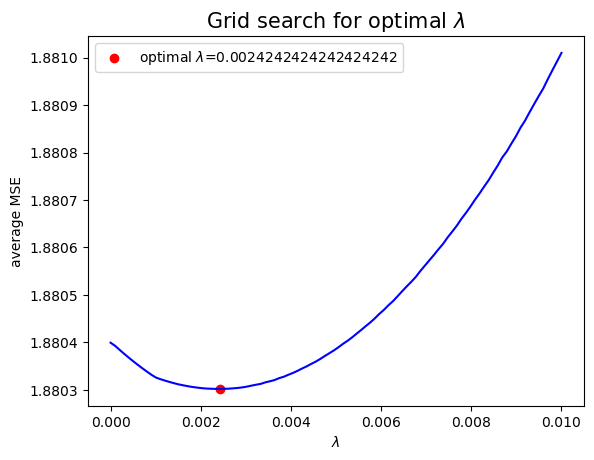

In [27]:
# find optimal lambda which has minimum score, since we use MSE as the scoring metric
optimal_lambda_lasso = min(cross_val_scores_lasso, key=cross_val_scores_lasso.get)

# create plots of average MSE during CV against lambda
plt.figure()
plt.title("Grid search for optimal $\lambda$", fontsize=15)
plt.plot(cross_val_scores_lasso.keys(), cross_val_scores_lasso.values(), "b")
plt.scatter(optimal_lambda_lasso, cross_val_scores_lasso[optimal_lambda_lasso], color="r", label=r"optimal $\lambda$={}".format(optimal_lambda_lasso))
plt.xlabel(r'$\lambda$')
plt.ylabel("average MSE")
plt.legend()
plt.show()

You can see in the plot our tuning processes involves taking $\lambda \in [0, 0.010)$ and performing 5-fold cross-validation to obtain a score (average MSE) for each $\lambda$. We can see that we have achieved our optimal lambda (lowest average MSE) at the minima of our curve, and we report the optimal value below.

In [28]:
print(f"optimal lambda: {optimal_lambda_lasso}")

optimal lambda: 0.0024242424242424242


1.2.2

Below, we have some code that will allow us to visualise the behaviour of each inferred parameter in $\boldsymbol \beta$ as we vary the Lasso penalty $\lambda$.

We randomly select a training/validation split, and then perform gradient descent to find the inferred parameters of $\boldsymbol \beta$ for a given penality $\lambda \in [0, 5)$. Then, we plot each inferred parameter as a function of $\lambda$.

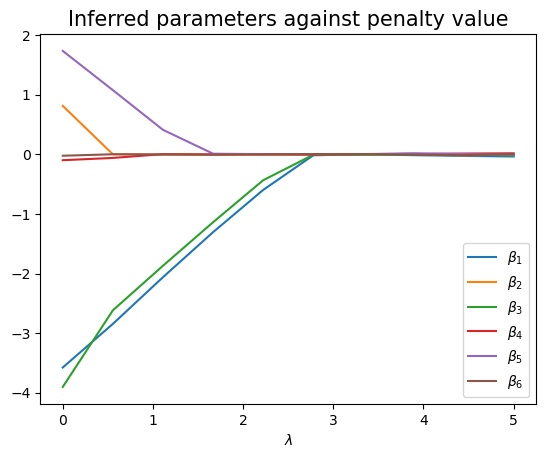

In [29]:
# pick a random training/validation split
split_number = np.random.randint(0, len(folds_indexes_1))
val_indexes = folds_indexes_1[split_number] # obtain indexes of validation fold
# define training indexes
train_indexes = list(set(range(y_train_shuffle.shape[0])) - set(val_indexes))

# extract of training and validation split
X_train_split = X_train_std_shuffle_aug[train_indexes, :]
y_train_split = y_train_shuffle[train_indexes]


X_val_split = X_train_std_shuffle_aug[val_indexes, :]
y_val_split = y_train_shuffle[val_indexes]

# define range of penalties to perform lasso for
penalty_range = np.linspace(0, 5, 10)
# initialise array to contain inferred betas for each lambda
beta_array = np.zeros((X_train_split.shape[1], len(penalty_range)))
# create array of betas
for i, penalty in enumerate(penalty_range):
    # fill appropriate column with inferred beta
    beta_array[:, i] = gradient_descent_lasso(X_train_split, y_train_split, np.ones(X_train_split.shape[1]), stop_criterion=1.0e-4, penalty=penalty, num_iterations=10000, print_its=False)

# plot the inferred parameters
plt.figure()
plt.title("Inferred parameters against penalty value", fontsize=15)
for i in range(1, len(beta_array)):
    plt.plot(penalty_range, beta_array[i, :], label=r"$\beta_{}$".format(i))
plt.xlabel(r"$\lambda$")
plt.legend()
plt.show()

We see that as $\lambda$ increases, our inferred parameters from our Lasso regression begin to converge to zero. Lasso regression is a shrinkage method, which promotes sparsity in our model by forcing the many of our regression parameters to have small values.

At $\lambda=0$ we obtain the parameters corresponding to the unregularised linear regression, which is unbiased but has high variance, and as we increase $\lambda$ the shrinkage begins to take effect and we trade higher bias for lower variance.

As $\lambda$ gets bigger more parameters get small, and so we get reduced variance in our regression model, however we also lose the unbiased property as our model converges to a nearly constant intercept-only model (all inferred parameters equal or close to zero), which is very overfitted and biased to the training data; it is identicallly the mean of the training data, as all other predictors are removed.

The parameters that go to zero/small fastest are those that are less robustly determined by the training data/least important to the model, and in our case it seems like these are $\beta_4$ and $\beta_6$. These correspond to the predictors 'Chord length' and 'Thickness' respectively, and they are likely not very important predictors in our model as Lasso tries to shrink their parameters to zero first.

Furthermore, the parameters that go to zero the slowest are $\beta_1$ and $\beta_3$, which correspond to 'Frequency' and 'Displacement'. This suggests these two predictors may have some form of linear relationship with the outcome, which we will explore later.

1.2.3

Now we will fix the penalty equal to the optimal penalty hyper-parameter found through our tuning process and retrain the model on our training dataset. We obtain predictions for both the training outcomes, and also the test outcomes, and report the metrics MSE and $R^2$ score for both the in-sample and out-of-sample respectively.

In [30]:
# predict y_train using the optimal lambda found in 1.2.1
y_train_pred_lasso = reg_predict_lasso(X_train_std_shuffle_aug, y_train_shuffle, X_train_std_aug, np.ones(X_train_std_shuffle_aug.shape[1]), penalty=optimal_lambda_lasso, stop_criterion=1.0e-4, num_iterations=10000)
lasso_optimal_train_mse = ms_error(y_train, y_train_pred_lasso)
lasso_optimal_train_r2 = r2_score(y_train, y_train_pred_lasso)
print(r'optimal lambda training set mean squared error:', lasso_optimal_train_mse)
print(r'optimal lambda training set R2 score:', lasso_optimal_train_r2)

optimal lambda training set mean squared error: 1.8756343466236876
optimal lambda training set R2 score: 0.9177309893452105


In [31]:
# predict y_test using the optimal lambda found in 1.2.1
y_test_pred_lasso = reg_predict_lasso(X_train_std_shuffle_aug, y_train_shuffle, X_test_std_aug, np.ones(X_train_std_shuffle_aug.shape[1]), penalty=optimal_lambda_lasso, stop_criterion=1.0e-4, num_iterations=10000)
lasso_optimal_test_mse = ms_error(y_test, y_test_pred_lasso)
lasso_optimal_test_r2 = r2_score(y_test, y_test_pred_lasso)
print(r'optimal lambda testing set mean squared error:', lasso_optimal_test_mse)
print(r'optimal lambda testing set R2 score:', lasso_optimal_test_r2)

optimal lambda testing set mean squared error: 1.9843068784773978
optimal lambda testing set R2 score: 0.9083210668002588


We also repeat this for if $\lambda=0$.

In [32]:
# predict y_train using lambda=0
y_train_pred_lasso_0 = reg_predict_lasso(X_train_std_shuffle_aug, y_train_shuffle, X_train_std_aug, np.ones(X_train_std_shuffle_aug.shape[1]), penalty=0, stop_criterion=1.0e-4, num_iterations=10000)
lasso_zero_train_mse = ms_error(y_train, y_train_pred_lasso_0)
lasso_zero_train_r2 = r2_score(y_train, y_train_pred_lasso_0)
print(r'lambda=0 training set mean squared error:', lasso_zero_train_mse)
print(r'lambda=0 training set R2 score:', lasso_zero_train_r2)

lambda=0 training set mean squared error: 1.8755566398170587
lambda=0 training set R2 score: 0.9177343977185504


In [33]:
# predict y_test using lambda=0
y_test_pred_lasso_0 = reg_predict_lasso(X_train_std_shuffle_aug, y_train_shuffle, X_test_std_aug, np.ones(X_train_std_shuffle_aug.shape[1]), penalty=0, stop_criterion=1.0e-4, num_iterations=10000)
lasso_zero_test_mse = ms_error(y_test, y_test_pred_lasso_0)
lasso_zero_test_r2 = r2_score(y_test, y_test_pred_lasso_0)
print(r'lambda=0 testing set mean squared error:', lasso_zero_test_mse)
print(r'lambda=0 testing set R2 score:', lasso_zero_test_r2)

lambda=0 testing set mean squared error: 1.9843926329399688
lambda=0 testing set R2 score: 0.9083171047731495


In [34]:
# generate table for both lambda values
lasso_indexes = ["optimal lambda", "zero lambda"]
lasso_column_labels = ["training MSE", "testing MSE", "training R2 score", "testing R2 score"]

lasso_data_array = np.zeros((2, 4))
lasso_data_array[0, :] = np.array([lasso_optimal_train_mse, lasso_optimal_test_mse, lasso_optimal_train_r2, lasso_optimal_test_r2])
lasso_data_array[1, :] = np.array([lasso_zero_train_mse, lasso_zero_test_mse, lasso_zero_train_r2, lasso_zero_test_r2])
lasso_df = pd.DataFrame(lasso_data_array, columns=lasso_column_labels, index=lasso_indexes)
lasso_df

training MSE  testing MSE  training R2 score  testing R2 score
optimal lambda      1.875634     1.984307           0.917731          0.908321
zero lambda         1.875557     1.984393           0.917734          0.908317

First, we notice that our in-sample metrics are better than the out-of-sample metrics for the optimal $\lambda$, which is not surprising since there is likely some bias towards the training data since it was used to train the model, whilst the testing data was unseen.

We see that $\lambda=0$ performs slightly better than optimal $\lambda$ on the training data with respect to both MSE and $R^2$ score metrics, whilst on the testing data our optimal $\lambda$ performs slightly better with respect to both metrics. This difference is likely due to the fact we obtained our optimal value by performing 5-fold cross-validation, since this value of $\lambda$ performed better than $\lambda=0$ as we see in the figure of average MSE against $\lambda$ above in 1.2.1. This validation over different folds enabled us to find a $\lambda$ that forms a model which is less biased on the training data. As a result, using this optimal value means we should get more accurate predictions for new test data, which we can see our results agree with as our out-of-sample MSE and $R^2$ score are slightly improved.

The improvement is very marginal, but since our optimal value is very close to zero we do not expect a drastic change.

#### 1.3 Elastic Nets (20 marks) 
1.3.1

In this question we will train a linear regression model, this time with an Elastic Net regulariser. We will perform a grid-search with 5-fold cross-validation to try and find an optimal hyper-parameter pair of $\lambda$ and $\alpha$, and then observe the behaviours/relationships of these hyper-parameters.

Our loss function is given by $L_{EN}(\boldsymbol\beta) = \frac{1}{2N}\|\boldsymbol y - \boldsymbol X \boldsymbol\beta - \boldsymbol 1 \beta_0\|^2 + \lambda\left(\alpha \|\boldsymbol\beta\|_1 + (1-\alpha)\|\boldsymbol \beta\|^2\right)$, which we will aim to minimise via gradient descent. `loss_func_elastic_net` has been defined to evaluate the loss function for Elastic Net regression. Similarly to Lasso regression, all the terms in our loss function for Elastic Net are convex, and so we know our gradient descent will yield the unique global minimiser of the loss function.

In [35]:
def loss_func_elastic_net(X, y, beta, penalty, alpha):
    """
    Evaluate the loss function for elastic net regression.
    Args:
    X: Augmented predictor data of size (n, d+1), where d is the number of predictors.
    y: outcome data of size (n, 1).
    beta: parameter prediction of size (d+1, 1).
    penalty: float, regularisation strength hyper-parameter lambda.
    alpha: float, relative importance of Ridge and Lasso regularisers.
    
    Returns:
    Loss, a float.
    """
    n, d = X.shape
    return (1/(2*n)) * np.inner(y - X @ beta, y - X @ beta) + penalty*(alpha*np.sum(np.abs(beta)) + (1-alpha)*np.inner(beta[1:], beta[1:]))

Essential to the gradient descent method is the gradient of the loss function itself, which we will now derive.

Let us write the loss function as:
$L_{EN} = \frac{1}{2N} \sum_{i=1}^N \left(y_i - \sum_{j=1}^p X_{ij}\beta_j - \beta_0\right)^2 + \lambda\left(\alpha \sum_{i=1}^N |\beta_i| + (1-\alpha)\sum_{i=1}^N \beta_i^2\right)$.

We derive our gradient of the above loss function as follows:

For $k=1, \dots, N$:
\begin{align}
\frac{\partial L_{EN}}{\partial \beta_k} &= \frac{1}{2N} \cdot 2 \cdot\sum_{i=1}^N \left(y_i - \sum_{j=1}^p X_{ij}\beta_j - \beta_0\right)(-X_{ik}) + \lambda \left(\alpha \rm sgn(\beta_k) + 2(1-\alpha)\beta_k \right)\\
&= -\frac{1}{N}\sum_{i=1}^N X^{T}_{ki}\left(y_i - \sum_{j=1}^pX_{ij}\beta_j-\beta_0\right) + \lambda \left(\alpha \rm sgn(\beta_k) + 2(1-\alpha)\beta_k \right)\\
&= \left(-\frac{1}{N}\boldsymbol X^T\left(\boldsymbol y- \boldsymbol X_{aug}\beta_{aug}\right) + \lambda \left(\alpha \rm sgn(\boldsymbol \beta) + 2(1-\alpha)\boldsymbol \beta \right)\right)_k\\
\implies \frac{\partial L_{EN}}{\partial \boldsymbol \beta}&= -\frac{1}{N}\boldsymbol X^T\left(\boldsymbol y- \boldsymbol X_{aug}\beta_{aug}\right) + \lambda \left(\alpha \rm sgn(\boldsymbol \beta) + 2(1-\alpha)\boldsymbol \beta \right)
\end{align}

Now for $k=0$:
\begin{align}
\frac{\partial L_{EN}}{\partial \beta_0} &= \frac{1}{2N} \cdot 2 \cdot\sum_{i=1}^N \left(y_i - \sum_{j=1}^p X_{ij}\beta_j - \beta_0\right)(-1)\\
&= -\frac{1}{N}\sum_{i=1}^N \left(\boldsymbol y - \boldsymbol X_{aug}\boldsymbol \beta_{aug} \right)_i
\end{align}

Again, we will use an interpolated gradient of the 1-norm as we discussed previously in the Lasso regression.
Below we define `get_grad_elastic_net` to help calculate the gradient of our loss function, and also `gradient_descent_elastic_net` to execute the gradient descent algorithm. We need to update the terms like so:

\begin{align}
\boldsymbol \beta &= \boldsymbol \beta - \alpha \frac{\partial L_{EN}}{\partial \boldsymbol \beta},\\
\beta_0 &= \beta_0 - \alpha \frac{\partial L_{EN}}{\partial \beta_0}, \quad \alpha = \text{learning rate}.
\end{align}

Note that in our implementation, we work with augmented data matrices as defined previously in the linear regression question (column of ones on the left), and so we perform our gradient descent with the $\beta_0$ augmented to the top of our $\boldsymbol \beta$ in our code. We ensure that we set the derivative of $\beta_0$ appropriately as the first entry within `get_grad_elastic_net`.

In [36]:
def get_grad_elastic_net(X, y, beta, penalty, alpha):
    """
    Get gradient of elastic net according to derived formulas.
    Arguments:
    X: Augmented predictor data of size (n, d+1), where d is the number of predictors.
    y: outcome data of size (n, 1).
    beta: intercept and parameters, a numpy array of size (d+1, 1).
    penalty: float, regularisation strength hyper-parameter lambda.
    alpha: float, relative importance of Ridge and Lasso regularisers.
    
    Returns:
    dbeta: gradient of the loss with respect to beta.
    """
    n = X.shape[0]
    dbeta = -(1/n) * (X.T @ (y - (X @ beta))) + penalty*(alpha*np.sign(beta) + 2*(1-alpha)*beta)
    dbeta[0] = -(1/n) * np.sum(y - X @ beta)
    return dbeta

In `gradient_descent_elastic_net`, we have selected our learing rate = $\frac{10}{N_{iterations}} \propto \frac{1}{N_{iterations}}$, which was carefully selected after observing convergence behaviour for a variety of proportionality constants.

Like in Lasso we implement a convergence criteria; we end the iterations if the absolute fractional change in cost of every 1000'th iteration is less than a certain threshold, given by keyword argument $stop\_criterion$.

In [37]:
def gradient_descent_elastic_net(X, y, beta, penalty=0, alpha=0, stop_criterion=1.0e-4, num_iterations=1000, print_its=False):
    """
    Perform gradient descent to obtain the maximum likelihood estimators for our elastic net regression parameters.
    Arguments:
    X: Augmented predictor data of size (n, d+1), where d is the number of predictors.
    y: outcome data of size (n, 1).
    beta: initial beta for gradient descent, of size (d+1, 1).
    penalty: float, regularisation strength hyper-parameter lambda.
    alpha: float, relative importance of Ridge and Lasso regularisers.
    stop_criterion: float, parameter to change the tolerance of convergence in stopping criteria.
    num_iterations: maximum number of iterations gradient descent shall update the parameters.
    print_its: boolean, dictate whether to print any iterations.

    Returns:
    beta: intercept and parameters, a numpy array of size (d+1, 1).
    """
    # initialise starting cost as infinity
    prev_cost = np.inf
    for i in range(num_iterations):
        learning_rate = 10/(i+1) # learning rate proportional to 1/N_iterations
        dbeta = get_grad_elastic_net(X, y, beta, penalty, alpha) # get gradient at the current point
        beta -= learning_rate * dbeta # move in opposite direction to gradient
        # convergence check on 1000'th iteration
        if i%1000 == 0 or i==num_iterations-1:
            # compute cost
            cost = loss_func_elastic_net(X, y, beta, penalty, alpha)
            if print_its:
                print("Iteration is: {}, Cost is: {}".format(i, cost))
            # stop criterion: if the percentage cost change less than provided stop criterion 
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return beta
            prev_cost = cost
    print("max iterations exceeded")
    return beta

1.3.2

Now, in order for us to employ our cross-validation we must define some functions that will assist us with this process. `reg_predict_elastic_net` utilises the gradient descent on training data to predict the outcome corresponding to some test predictors, `score_elastic_net` calculates the MSE of the prediction, `cross_validation_score_elastic_net` calculates the average score over all folds passed in, and `get_cross_validation_scores_elastic_net` allows us to perform a grid search over each $\alpha$ and $\lambda$ combination.

In [38]:
def reg_predict_elastic_net(X_train, y_train, X_test, beta, penalty=0, alpha=0, stop_criterion=1.0e-4, num_iterations=1000):
    """
    Train elastic net regression model via gradient descent and make prediction on test data.
    Args:
    X_train: Augmented train predictor data of size (n, d+1), where d is the number of predictors.
    y_train: outcome data of size (n, 1) associated with the train predictor data.
    X_test: Augmented test predictor data of size (k, d+1), where d is the number of predictors.
    beta: initial beta for gradient descent, of size (d+1, 1).
    penalty: float, regularisation strength hyper-parameter lambda.
    alpha: float, relative importance of Ridge and Lasso regularisers.
    stop_criterion: float, parameter to change the tolerance of convergence in stopping criteria.
    num_iterations: maximum number of iterations gradient descent shall update the parameters.
    
    Returns:
    y_pred: predicted outcome data associated with X_test, size (k, 1).
    """
    # find our augmented vector of parameters using gradient descent
    beta_converged = gradient_descent_elastic_net(X_train, y_train, beta, penalty=penalty, alpha=alpha,stop_criterion=stop_criterion, num_iterations=num_iterations)
    y_pred = predict_with_estimate(X_test, beta_converged)
    return y_pred

In [39]:
def score_elastic_net(X_train, y_train, X_test, y_test, beta, penalty=0, alpha=0, stop_criterion=1.0e-4, num_iterations=1000):
    """
    Calculate mean squared error of trained elastic net regression model on test data.
    Args:
    X_train: Augmented train predictor data of size (n, d+1), where d is the number of predictors.
    y_train: outcome data of size (n, 1) associated with the train predictor data.
    X_test: Augmented test  data of size (k, d+1), where d is the number of predictors.
    beta: initial beta for gradient descent, of size (d+1, 1).
    penalty: float, regularisation strength hyper-parameter lambda.
    alpha: float, relative importance of Ridge and Lasso regularisers.
    stop_criterion: float, parameter to change the tolerance of convergence in stopping criteria.
    num_iterations: maximum number of iterations gradient descent shall update the parameters.
    
    Returns:
    MSE, a float.
    """
    y_pred = reg_predict_elastic_net(X_train, y_train, X_test, beta, penalty=penalty, alpha=alpha, stop_criterion=stop_criterion, num_iterations=num_iterations)
    return ms_error(y_test, y_pred) # use mean squared error as score

In [40]:
def cross_validation_score_elastic_net(X_train, y_train, folds, beta, penalty, alpha, stop_criterion=1.0e-4, num_iterations=1000):
    """
    Calculate the average mean squared error over T-fold cross-validation.
    Args:
    X_train: Augmented train predictor data of size (n, d+1), where d is the number of predictors.
    y_train: outcome data of size (n, 1) associated with the train predictor data.
    folds: An T-size array of arrays containing the indexes of each fold.
    beta: initial beta for gradient descent, of size (d+1, 1).
    penalty: float, regularisation strength hyper-parameter lambda.
    alpha: float, relative importance of Ridge and Lasso regularisers.
    stop_criterion: float, parameter to change the tolerance of convergence in stopping criteria.
    num_iterations: maximum number of iterations gradient descent shall update the parameters.
    
    Returns:
    Average mean squared error, a float.
    """
    scores = []
    for i in range(len(folds)):
        val_indexes = folds[i] # extract validation fold indexes
        # extract training fold indexes
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))

        # split the data into training and validation folds
        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]


        X_val_i = X_train[val_indexes, :]
        y_val_i = y_train[val_indexes]

        # append the score for this fold
        score_i = score_elastic_net(X_train_i, y_train_i, X_val_i, y_val_i, beta, penalty=penalty, alpha=alpha, stop_criterion=stop_criterion, num_iterations=num_iterations)
        scores.append(score_i)

    # Return the average score
    return np.mean(scores)

In [41]:
def get_cross_validation_scores_elastic_net(X_train, y_train, folds, beta, penalty_range, alpha_list, stop_criterion=1.0e-4, num_iterations=1000):
    """
    Get the T-fold cross-validation scores for each alpha and hyper-parameter lambda pair we want to consider.
    Args:
    X_train: Augmented train predictor data of size (n, d+1), where d is the number of predictors.
    y_train: outcome data of size (n, 1) associated with the train predictor data.
    folds: A T-size array of arrays containing the indexes of each fold.
    beta: initial beta for gradient descent, of size (d+1, 1).
    penalty_range: a range of regularisation strength hyper-parameter lambda we want to perform grid search on.
    alpha_list: list of alphas, the relative importance of Ridge and Lasso regularisers we want to perform grid search on.
    stop_criterion: float, parameter to change the tolerance of convergence in stopping criteria.
    num_iterations: maximum number of iterations gradient descent shall update the parameters.
    
    Returns:
    alpha_penalty_map: a dict, with alpha_list values as keys, mapping to values that are also dictionaries.
    Each of these dictionaries has keys from penalty_range, mapping to values corresponding the CV scores of these.
    """
    # initialise our dictionary
    alpha_penalty_map = {}
    for alpha in alpha_list:
        print(f"starting cross validation for alpha={alpha}")
        # initialise our dictionary mapped to by alpha
        penalty_scores = {}
        for penalty in penalty_range:
            # map each penalty to term to corresponding score
            penalty_scores[penalty] = cross_validation_score_elastic_net(X_train, y_train, folds, beta, penalty, alpha, stop_criterion=stop_criterion, num_iterations=num_iterations)
        # map alpha to our dictionary of penalty scores
        alpha_penalty_map[alpha] = penalty_scores
        print(f"finished cross validation for alpha={alpha}")
    return alpha_penalty_map

We are now ready to perform our grid search with 5-fold cross validation for our optimal $\lambda$ over each $\alpha$. We can reuse our shuffled data and fold indexes that we made in Lasso regression.

We scan over 100 values of $\lambda \in [0, 0.01)$, which is a range chosen after observing large cross-validation MSE for $\lambda$ outside this range.

Our initial $\beta$ guess is $\boldsymbol 1$, but this was simply for convenience and should not change the results.

Our $stop\_criterion$ was set to $10^{-4}$ and we used a maximum of 10000 iterations, which again was chosen after optimising for convergence and also computational speed.

In [42]:
# define alpha list
alpha_list = np.array([0.1, 0.5, 0.9])
# define range of penalties
lambda_range_elastic_net = np.linspace(0, 0.01, 100)
alpha_penalty_map = get_cross_validation_scores_elastic_net(X_train_std_shuffle_aug, y_train_shuffle, folds_indexes_1, np.ones(X_train_std_shuffle_aug.shape[1]), lambda_range_elastic_net, alpha_list, stop_criterion=1.0e-4, num_iterations=10000)

starting cross validation for alpha=0.1
finished cross validation for alpha=0.1
starting cross validation for alpha=0.5
finished cross validation for alpha=0.5
starting cross validation for alpha=0.9
finished cross validation for alpha=0.9


Now we visualise our grid search with 5-fold cross validation across our $\alpha$'s and $\lambda$'s.

alpha = 0.1, optimal lambda: 0.00010101010101010101
alpha = 0.5, optimal lambda: 0.00020202020202020202
alpha = 0.9, optimal lambda: 0.0009090909090909091


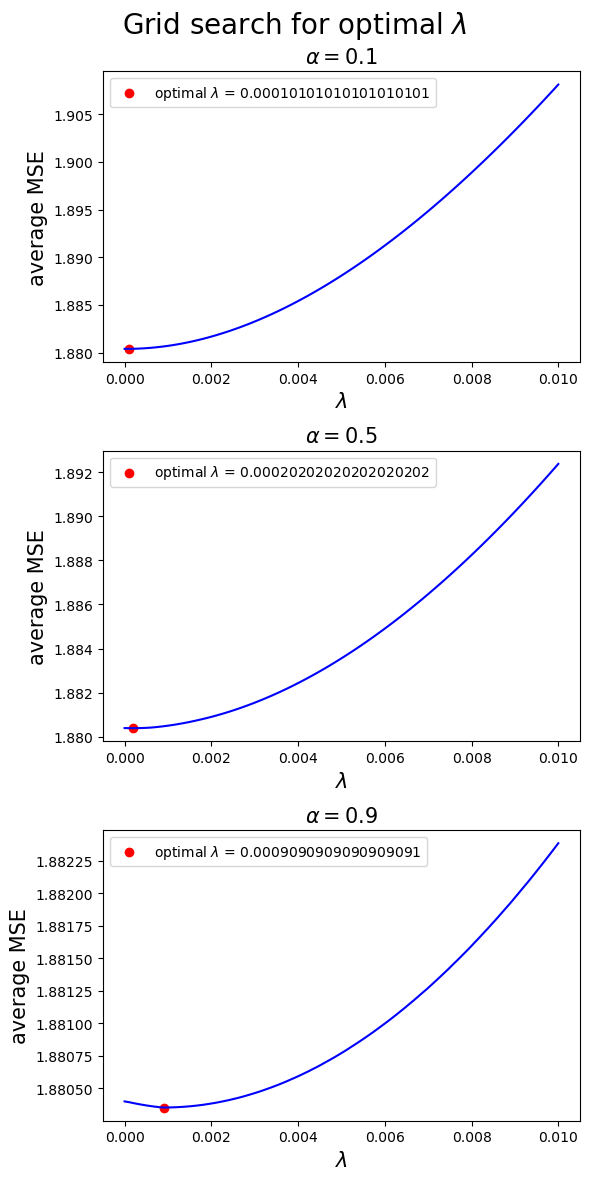

In [43]:
# create plots of average MSE during CV against lambda
optimal_lambda_map = {}
fig, axs = plt.subplots(3, 1, figsize=(6, 12))
fig.suptitle(r"Grid search for optimal $\lambda$", fontsize=20)
for alpha, cross_val_scores, ax in zip(alpha_penalty_map.keys(), alpha_penalty_map.values(), axs.ravel()):
    optimal_lambda = min(cross_val_scores, key=cross_val_scores.get)
    optimal_lambda_map[alpha] = optimal_lambda
    ax.plot(cross_val_scores.keys(), cross_val_scores.values(), "b")
    ax.scatter(optimal_lambda, cross_val_scores[optimal_lambda], color="r", label=r"optimal $\lambda$ = {}".format(optimal_lambda))
    ax.set_xlabel(r'$\lambda$', fontsize=15)
    ax.set_ylabel("average MSE", fontsize=15)
    ax.set_title(r'$\alpha={}$'.format(alpha), fontsize=15)
    ax.legend()
    print(f"alpha = {alpha}, optimal lambda: {optimal_lambda}")
plt.tight_layout()

Now, for each value of $\alpha$, we will re-train using its corresponding optimal $\lambda$, and report the out-of-sample MSE and $R^2$ scores.

In [44]:
elastic_net_comparison_columns = ["train MSE", "test MSE", "train R2 score", "test R2 score"]
elastic_net_comparison_indexes = ["alpha=0.1", "alpha=0.5", "alpha=0.9"]
elastic_net_comparison_array = np.zeros((len(elastic_net_comparison_indexes), len(elastic_net_comparison_columns)))
for idx, alpha in enumerate(optimal_lambda_map.keys()):
    # predict y_train using the optimal lambda found above
    optimal_lambda = optimal_lambda_map[alpha]
    y_train_pred_elastic_net = reg_predict_elastic_net(X_train_std_shuffle_aug, y_train_shuffle, X_train_std_aug, np.ones(X_train_std_shuffle_aug.shape[1]), penalty=optimal_lambda, alpha=alpha, stop_criterion=1.0e-4, num_iterations=10000)
    # predict y_test using the optimal lambda found above
    y_test_pred_elastic_net = reg_predict_elastic_net(X_train_std_shuffle_aug, y_train_shuffle, X_test_std_aug, np.ones(X_train_std_shuffle_aug.shape[1]), penalty=optimal_lambda, alpha=alpha, stop_criterion=1.0e-4, num_iterations=10000)
    elastic_net_comparison_array[idx, :] = [ms_error(y_train, y_train_pred_elastic_net), ms_error(y_test, y_test_pred_elastic_net), r2_score(y_train, y_train_pred_elastic_net), r2_score(y_test, y_test_pred_elastic_net)]

In [45]:
elastic_net_comparison_df = pd.DataFrame(elastic_net_comparison_array, columns=elastic_net_comparison_columns, index=elastic_net_comparison_indexes)
elastic_net_comparison_df

train MSE  test MSE  train R2 score  test R2 score
alpha=0.1   1.875560  1.984734        0.917734       0.908301
alpha=0.5   1.875562  1.984767        0.917734       0.908300
alpha=0.9   1.875578  1.984695        0.917733       0.908303

Based on these two metrics, we infer that our optimal $\alpha$ is 0.9 due to a slight improvements in both mean squared error and $R^2$ score compared to the other values of $\alpha$ on our testing data.

This implies that a more dominant Lasso penalty is better; this suggests that perhaps some of our predictors aren't as important in our linear regression model, and since Lasso forces some of these towards zero, we get better performance.

In [46]:
# save the MSE and R2 corresponding to optimal alpha, lambda pair for later comparison
alpha = 0.9
y_train_pred_elastic_net = reg_predict_elastic_net(X_train_std_shuffle_aug, y_train_shuffle, X_train_std_aug, np.ones(X_train_std_shuffle_aug.shape[1]), penalty=optimal_lambda_map[alpha], alpha=alpha, stop_criterion=1.0e-4, num_iterations=10000)
elastic_net_train_mse = ms_error(y_train, y_train_pred_elastic_net)
elastic_net_train_r2 = r2_score(y_train, y_train_pred_elastic_net)
y_test_pred_elastic_net = reg_predict_elastic_net(X_train_std_shuffle_aug, y_train_shuffle, X_test_std_aug, np.ones(X_train_std_shuffle_aug.shape[1]), penalty=optimal_lambda_map[alpha], alpha=alpha, stop_criterion=1.0e-4, num_iterations=10000)
elastic_net_test_mse = ms_error(y_test, y_test_pred_elastic_net)
elastic_net_test_r2 = r2_score(y_test, y_test_pred_elastic_net)

1.3.3

For each $\alpha$, we retrain our Elastic Net regreesion using the corresponding optimal $\lambda$, and visualise the inferred parameters below.

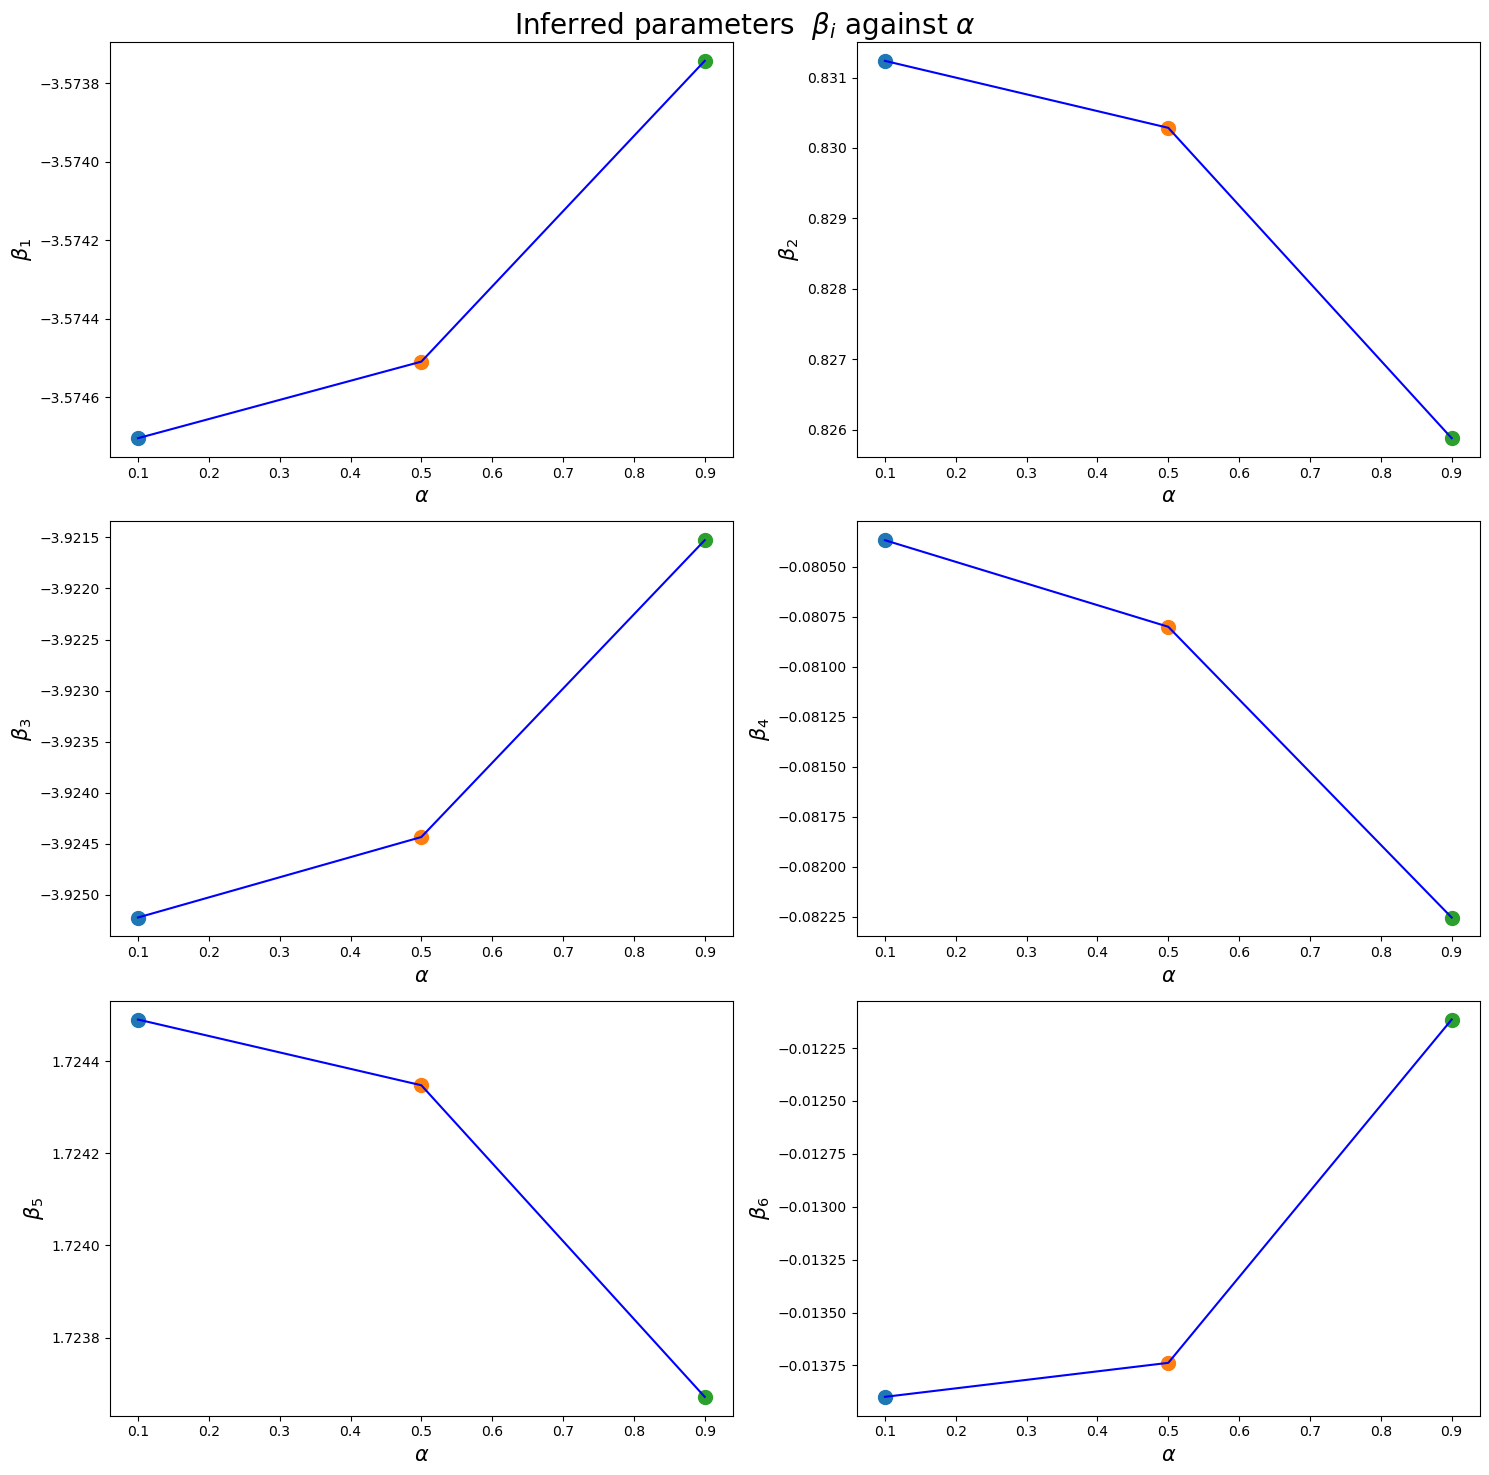

In [47]:
parameter_map = {}
for alpha in optimal_lambda_map.keys():
    # predict y_train using the optimal lambda found above
    optimal_lambda = optimal_lambda_map[alpha]
    parameter_map[alpha] = gradient_descent_elastic_net(X_train_std_shuffle_aug, y_train_shuffle, np.ones(X_train_std_shuffle_aug.shape[1]), penalty=optimal_lambda, alpha=alpha,stop_criterion=1.0e-4, num_iterations=10000)

# plot each inferred entry
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle(r"Inferred parameters  $\beta_i$ against $\alpha$", fontsize=20)
for i, ax in zip(np.arange(1, X_train_std_shuffle_aug.shape[1]), axs.ravel()):
    ax.plot(optimal_lambda_map.keys(), [beta[i] for beta in parameter_map.values()], "b")
    for alpha in parameter_map.keys():
        ax.scatter(alpha, parameter_map[alpha][i], s=100)
    ax.set_xlabel(r"$\alpha$", fontsize=15)
    ax.set_ylabel(r"$\beta_{}$".format(i), fontsize=15)
plt.tight_layout()
plt.show()

Our visualisation of the inferred parameters shows that for larger $\alpha$, it appears that all our parameters besides $\beta_4$ get smaller in magnitude (closer to zero). This can be explained by the fact that when $\alpha=0.9$, the Lasso penalty becomes more dominant, which is more aggressive in shrinking the parameters to zero than Ridge is, and thus leads to smaller magnitude parameters than when Ridge is more dominant (i.e. $\alpha=0.1$).

For $\alpha=0$, our elastic net regression reduces to just Ridge regression as the Lasso term vanishes, so our parameters inferred are simply those of Ridge regression. Similarly, for $\alpha=1$, our elastic net regression reduces to just Lasso regression, so our parameters inferred are simply those of Lasso regression. At $\alpha=0.5$, we have equal weighting of our Lasso and Ridge terms.

#### 1.4 kNN regression (10 marks)
1.4.1

Now, we move away from linear regression models and consider something different, a distance based model in kNN regression. In this question we will try to find the optimal _k_ for our kNN model via 5-fold cross-validation, and then compare the performance of this model with the linear regression models we previously trained.

kNN regression predicts the outcome of a datapoint by finding the _k_ nearest neighbours in the training data, and calculating the average outcomes over these _k_ neighbours. This means that in order to predict the outcome of a test point, we need to know the distance of this test point to each training data point, and then select the _k_ nearest.


We will use Euclidean distance as our distance metric in this coursework.

We first implement the Euclidean distance $d$ in `euclidean_distance`, defined as
\begin{align}
d(\boldsymbol p, \boldsymbol q) = \sqrt{\sum_{i=1}^D{(q_i-p_i)^2}} \, ,
\end{align}
where $\boldsymbol p$ and $\boldsymbol q$ are the two points in our $D$-dimensional Euclidean space.

In [48]:
def euclidian_distance(p, q):
    """
    Calculate euclidean distance between p and the columns of q.
    Args:
    p: array of size N
    q: array of shape (N, k)
    
    Returns:
    Array of size k
    """
    return np.sqrt(np.sum(np.square(q-p), axis=1))

We now need a function to find the _k_ nearest neighbours in our training set for every test data point, which we implement in `k_neighbours`.

In [49]:
def k_neighbours(X_train, X_test, k=5, return_distance=False):
    """
    Find the k-neighbours in X_train that are nearest to each point in X_test.
    Args:
    X_train: Predictor array of size (m, d), where d is the number of predictors.
    X_test: Predictor array of size (n, d), where d is the number of predictors.
    k: int, the number of nearest neighbours to find.
    return_distance: bool, if true, return the distances for k nearest neighbours.
    
    Returns:
    neigh_ind: an array of the size (n, k), each row containing indices of the nearest k-neighbours to each test point.
    dist: an array of size (n, k), each row containing the distance of the nearest k-neighbours to each test point.
    """
    n_neighbours = k
    dist = []
    neigh_ind = []

    # compute distance from each point x_text in X_test to all points in X_train (hint: use python's list comprehension: [... for x_test in X_test])
    point_dist = [euclidian_distance(x_test, X_train) for x_test in X_test]

    # determine which k training points are closest to each test point
    for row in point_dist:
        enum_neigh = enumerate(row)
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

        ind_list = [tup[0] for tup in sorted_neigh]
        dist_list = [tup[1] for tup in sorted_neigh]

        dist.append(dist_list)
        neigh_ind.append(ind_list)

    # return distances together with indices of k nearest neighbouts
    if return_distance:
        return np.array(dist), np.array(neigh_ind)

    return np.array(neigh_ind)

Now, in order for us to employ our 5-fold cross-validation we must define some functions that will assist us with this process. `reg_predict_knn` utilises our `k_neighbours` to predict the outcome for a test point by taking the average of the outcomes of its _k_ nearest neighbours. `score_knn` calculates the MSE of the prediction. `cross_validation_score_knn` calculates the average score over all folds passed in, and `choose_best_k` allows us to obtain the cross validation score for each value of _k_ we scan over.

In [50]:
def reg_predict_knn(X_train, y_train, X_test, k=20):
    """
    Predict outcome array based on k nearest neighbours with equal weights.
    Args:
    X_train: Predictor array of size (m, d), where d is the number of predictors.
    y_train: outcome array of size (m, 1), associated with the train predictor data.
    X_test: Predictor array of size (n, d), where d is the number of predictors.
    k: int, the number of nearest neighbours to consider.
    
    Returns:
    y_pred: outcome prediction of size (n, 1).
    """
    # each of the k neighbours contributes equally to the classification of any data point in X_test  
    neighbours = k_neighbours(X_train, X_test, k=k)
    # compute mean over k neighbours labels
    y_pred = np.array([np.mean(y_train[neighbour]) for neighbour in neighbours])

    return y_pred

In [51]:
def score_knn(X_train, y_train, X_test, y_test, k=5):
    """
    Predict outcome array based on k nearest neighbours and test the accuracy.
    Args:
    X_train: Predictor array of size (m, d), where d is the number of predictors.
    y_train: outcome array of size (m, 1), associated with the train predictor data.
    X_test: Predictor array of size (n, d), where d is the number of predictors.
    y_test: true outcome array of size (n, 1), associated with the test predictor data.
    k: int, the number of nearest neighbours to consider.
    """
    # make prediction using k nearest neighbours
    y_pred = reg_predict_knn(X_train, y_train, X_test, k=k)
    return ms_error(y_test, y_pred) # use mean squared error as score

In [52]:
def cross_validation_score_knn(X_train, y_train, folds, k):
    """
    Perform T-fold cross-validation of for a given k.
    Args:
    X_train: Predictor array of size (m, d), where d is the number of predictors.
    y_train: outcome array of size (m, 1), associated with the train predictor data.
    folds: A T-size array of arrays containing the indexes of each fold.
    k: int, the number of nearest neighbours to consider.
    
    Returns:
    Average mean squared error, a float.
    """
    scores = []
    for i in range(len(folds)):
        val_indexes = folds[i] # get validation fold indexes
        # get training fold indexes
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
        
        # extract training and validation folds
        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]


        X_val_i = X_train[val_indexes, :]
        y_val_i = y_train[val_indexes]

        # append the score each the current fold
        score_i = score_knn(X_train_i, y_train_i, X_val_i, y_val_i, k=k)
        scores.append(score_i)

    # Return the average score
    return np.mean(scores)

In [53]:
def choose_best_k(X_train, y_train, folds, k_range):
    """
    Find the optimal k for k in a given k_range using T-fold cross-validation.
    Args:
    X_train: Predictor array of size (m, d), where d is the number of predictors.
    y_train: outcome array of size (m, 1), associated with the train predictor data.
    folds: A T-size array of arrays containing the indexes of each fold.
    k: a range of ints corresponding to the number of nearest neighbours to consider at each cross-validation.
    
    Returns:
    best_k: int, the k value corresponding to the smallest mean squared error.
    """
    k_scores = np.zeros((len(k_range),))

    for i, k in enumerate(k_range):
        k_scores[i] = cross_validation_score_knn(X_train, y_train, folds, k)
        print(f'CV_ACC@k={k}: {k_scores[i]:.3f}')

    best_k_index = np.argmin(k_scores) # choose best k as lowest score (mean squared error)
    return k_range[best_k_index]

We are now ready to search for our optimal _k_ by passing in our previously shuffled data and fold indexes.

In [54]:
# use grid search with 5-fold cross-validation to find optimal hyper-parameter k
best_k = choose_best_k(X_train_std_shuffle, y_train_shuffle, folds_indexes_1, np.arange(1, 31))

print('best_k:', best_k)

CV_ACC@k=1: 5.279
CV_ACC@k=2: 3.851
CV_ACC@k=3: 3.434
CV_ACC@k=4: 3.181
CV_ACC@k=5: 3.087
CV_ACC@k=6: 3.034
CV_ACC@k=7: 2.995
CV_ACC@k=8: 2.987
CV_ACC@k=9: 2.991
CV_ACC@k=10: 2.992
CV_ACC@k=11: 2.996
CV_ACC@k=12: 3.006
CV_ACC@k=13: 3.011
CV_ACC@k=14: 3.016
CV_ACC@k=15: 3.029
CV_ACC@k=16: 3.040
CV_ACC@k=17: 3.058
CV_ACC@k=18: 3.085
CV_ACC@k=19: 3.099
CV_ACC@k=20: 3.114
CV_ACC@k=21: 3.138
CV_ACC@k=22: 3.158
CV_ACC@k=23: 3.174
CV_ACC@k=24: 3.200
CV_ACC@k=25: 3.219
CV_ACC@k=26: 3.237
CV_ACC@k=27: 3.257
CV_ACC@k=28: 3.278
CV_ACC@k=29: 3.293
CV_ACC@k=30: 3.311
best_k: 8


1.4.2

Let us use the best _k_ value we found in our cross-validation to retrain our kNN model, and report the in-sample, and out-of-sample MSE and $R^2$ scores.

In [55]:
y_train_pred_knn = reg_predict_knn(X_train_std_shuffle, y_train_shuffle, X_train_std, k=best_k)
y_test_pred_knn = reg_predict_knn(X_train_std_shuffle, y_train_shuffle, X_test_std, k=best_k)
knn_train_mse = ms_error(y_train, y_train_pred_knn)
knn_train_r2 = r2_score(y_train, y_train_pred_knn)
knn_test_mse = ms_error(y_test, y_test_pred_knn)
knn_test_r2 = r2_score(y_test, y_test_pred_knn)
print(r'training set mean squared error:', knn_train_mse)
print(r'training set R2 score:', knn_train_r2)
print(r'testing set mean squared error:', knn_test_mse)
print(r'testing set R2 score:', knn_test_r2)

training set mean squared error: 2.205176116058986
training set R2 score: 0.9032766393330809
testing set mean squared error: 3.0179485395846983
testing set R2 score: 0.8605647616495959


Now we shall compare the performance of our kNN model with the unregularised and regularised linear regression models we created previously.

In [56]:
# create comparison table
comparison_indexes = ["standard linear reg", "lasso reg", "elastic net reg", "knn reg"]
comparison_column_labels = ["train MSE", "train R2 score", "test MSE", "test R2 score"]
comparison_array = np.zeros((len(comparison_indexes), len(comparison_column_labels)))
comparison_array[0, :] = np.array([linreg_train_mse, linreg_train_r2, linreg_test_mse, linreg_test_r2])
comparison_array[1, :] = np.array([lasso_optimal_train_mse, lasso_optimal_train_r2, lasso_optimal_test_mse, lasso_optimal_test_r2])
comparison_array[2, :] = np.array([elastic_net_train_mse, elastic_net_train_r2, elastic_net_test_mse, elastic_net_test_r2])
comparison_array[3, :] = np.array([knn_train_mse, knn_train_r2, knn_test_mse, knn_test_r2])
comparison_df = pd.DataFrame(comparison_array, columns=comparison_column_labels, index=comparison_indexes)
comparison_df

train MSE  train R2 score  test MSE  test R2 score
standard linear reg   1.875557        0.917734  1.984390       0.908317
lasso reg             1.875634        0.917731  1.984307       0.908321
elastic net reg       1.875578        0.917733  1.984695       0.908303
knn reg               2.205176        0.903277  3.017949       0.860565

From the above comparison table, it appears that our kNN regression model performs a lot worse on both the training and testing data than all three of the linear regression models we trained in the first three parts of the question. The MSE is significantly higher, and the $R^2$ score is lower, which seems to suggest that our kNN regression model is not the best fit for predicting sound pressure in our airfoil data. This seems to suggest that our predictors being nearby to each other in terms of Euclidean distance does not necessarily imply that our test outcome is also close to the nearby outcomes in a similar manner.

Also, the significant decrease in performance on the testing data compared to training for kNN suggests there may be some overfitting going on; perhaps our optimal number of neighbours $k$ of the training data may be far different than the testing data. The superior performance of the linear regression models could also be explained by a linear relationship with our predictors, which we will verify below. Since kNN is not a linear model, it does not see any benefit in its performance from this property.

Lasso regresssion seems to give the best MSE when applied to the testing data, which suggests that perhaps there are some unimportant predictors that we have prevented overfitting our model to by aggressively forcing the parameters corresponding to these to zero. The difference in the MSE and $R^2$ scores between all the linear regression models are very similar overall though, which is probably down to the fact our optimal $\lambda$ in both Lasso and Elastic Net were very small, and thus create a model that is not too indifferent from our standard linear regression.

Furthermore, if there was any noisy data/outliers in our training dataset, or if some of the predictors are less significant than others, this could very easily affect the predictions of nearby test points in a negative manner. Having more training data would also help the performance of our kNN model, as if some of our test data are not actually very close to any of the training points, taking the average of the _k_ nearest neighbours may not give the best prediction (best $k$ may not be optimal like we already discussed).

Let us explore the relationship between the predictors and the outcome further.

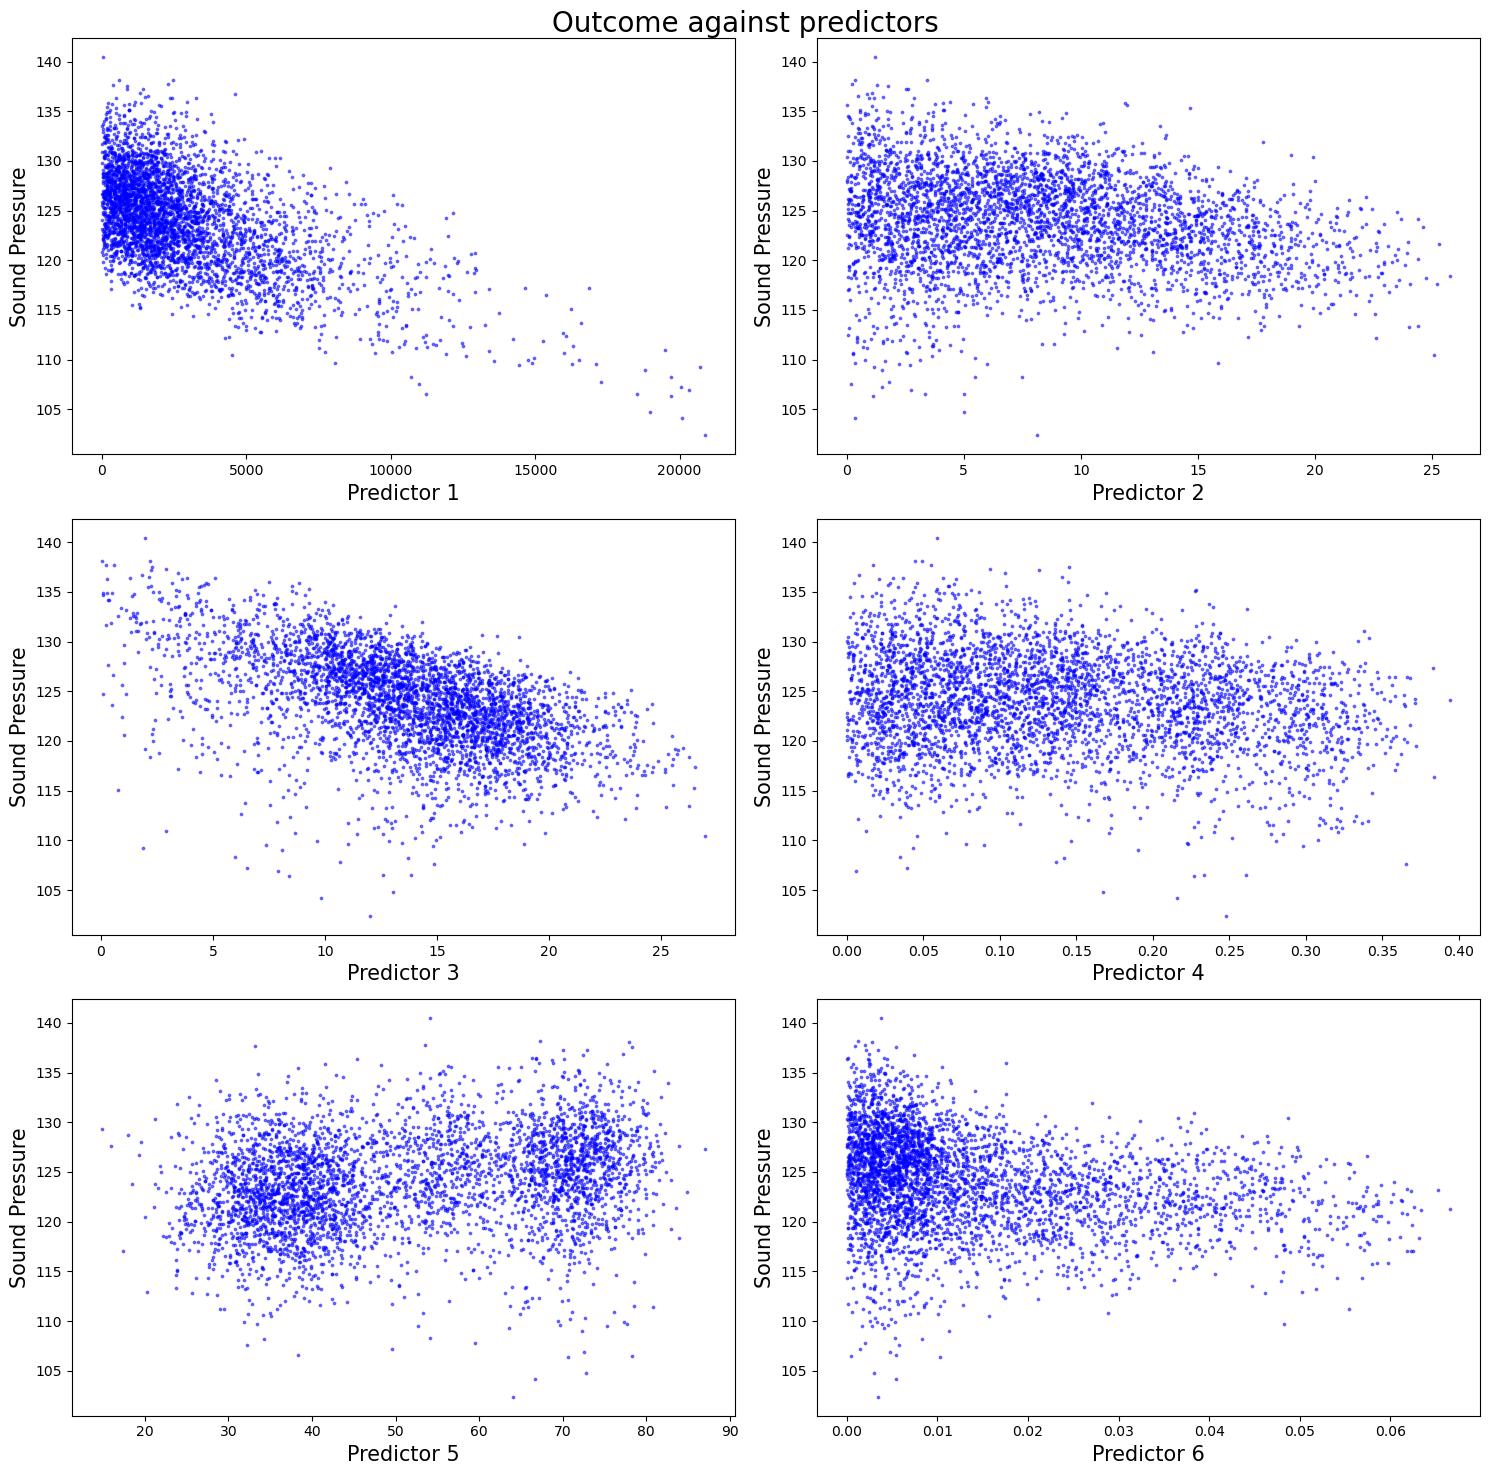

In [57]:
# plot each inferred entry
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle(r"Outcome against predictors", fontsize=20)
for i, ax in zip(np.arange(1, X_train.shape[1]+1), axs.ravel()):
    ax.scatter(X_train[:, i-1], y_train, color="b", s=3, alpha=0.5)
    ax.set_ylabel(r"Sound Pressure", fontsize=15)
    ax.set_xlabel(f"Predictor {i}", fontsize=15)
plt.tight_layout()
plt.show()

We notice from these plots that predictor 1 and predictor 3, which correspond to Frequency and Displacement, appear to have some kind of negative linear correlation. This explains our observation of how the $\beta_1$ and $\beta_3$ terms in our Lasso regression were the slowest to converge to zero as penalty parameter $\lambda$ is increased; since these predictors likely have some linear relationship with our outcome Sound Pressure, they are the most significant in our linear regression models.

This could also explain why kNN was not as effective as the linear regression models, since it cannot capture the linear relationship behaviour of these two predictors with the outcome; kNN regression is based on euclidean distance of predictors rather than a linear combination of them.

## Task 2: Classification  (50 marks)



#### 2.1 Random forest (20 marks)
2.1.1

We now turn from Regression to Classification, and switch our attention to another dataset.

In this first part of the question, we shall explore how the hyper-parameters number of trees $B$ and max_depth of trees $max\_depth$, and then try to find the optimal hyper-parameter pair via grid-search with 4-fold cross-validation.

To build our random forest classifier, we first need to read in our diabetes training dataset.

In [58]:
# load training data as pandas data frames
diabetes_data = pd.read_csv('./diabetes_samples.csv', decimal=',')
# print shape and last 5 rows
print(diabetes_data.shape)
diabetes_data.tail()

(273, 15)


patient_number  cholesterol  glucose  hdl_chol  chol_hdl_ratio  age  \
268              57          189       96        47             4.0   28   
269             222          307       87        58             5.3   49   
270              81          293       85        94             3.1   31   
271             134          138       95        40             3.5   38   
272              56          146       77        60             2.4   28   

     height  weight   bmi  systolic_bp  diastolic_bp  waist  hip  \
268      64     200  34.3          136            52     38   45   
269      67     181  28.3          120            80     41   42   
270      67     200  31.3          110            90     41   42   
271      60     138  26.9          140            90     31   39   
272      64     126  21.6          120            90     28   32   

     waist_hip_ratio     diabetes  
268             0.84  No diabetes  
269             0.98  No diabetes  
270             0.98  No diabetes  
271             0.79  No diabetes  
272             0.88  No diabetes

Let us check that our training data is clean and.

In [59]:
print(f"Total null values = {diabetes_data.isnull().sum().sum()}")
print(f"Total repeated values = {diabetes_data.duplicated().sum()}")
print(f"Dataframe types = {diabetes_data.dtypes}")

Total null values = 0
Total repeated values = 0
Dataframe types = patient_number       int64
cholesterol          int64
glucose              int64
hdl_chol             int64
chol_hdl_ratio     float64
age                  int64
height               int64
weight               int64
bmi                float64
systolic_bp          int64
diastolic_bp         int64
waist                int64
hip                  int64
waist_hip_ratio    float64
diabetes            object
dtype: object


We have no null values, no repeated values, and also all of our predictors are numeric (int64 or float64). Our label classification column 'diabetes' is non-numeric, so let us verify that it is indeed binary.

In [60]:
print(f"Total classification labels = {diabetes_data.loc[:, 'diabetes'].nunique()}")

Total classification labels = 2


We notice that patient_number should be set to the index of the patient data, since it is likely to be unrelated whether a patient is diabetic or not, since it is more for identification purposes.

In [61]:
# set column id as dataframe index
diabetes_data_1 = diabetes_data.set_index(diabetes_data['patient_number']).drop(diabetes_data.columns[0], axis=1)

# check
diabetes_data_1.tail()

cholesterol  glucose  hdl_chol  chol_hdl_ratio  age  height  \
patient_number                                                                
57                      189       96        47             4.0   28      64   
222                     307       87        58             5.3   49      67   
81                      293       85        94             3.1   31      67   
134                     138       95        40             3.5   38      60   
56                      146       77        60             2.4   28      64   

                weight   bmi  systolic_bp  diastolic_bp  waist  hip  \
patient_number                                                        
57                 200  34.3          136            52     38   45   
222                181  28.3          120            80     41   42   
81                 200  31.3          110            90     41   42   
134                138  26.9          140            90     31   39   
56                 126  21.6          120            90     28   32   

                waist_hip_ratio     diabetes  
patient_number                                
57                         0.84  No diabetes  
222                        0.98  No diabetes  
81                         0.98  No diabetes  
134                        0.79  No diabetes  
56                         0.88  No diabetes

Next, we shall convert our categorical labels to numerical labels, representing positive diagnosis (i.e. diabetic) as 1.0, and negative diagnosis (i.e. non diabetic) as -1.0.

For random forest classification, although the predictor data takes values over different ranges, we do not need to standardise it since the classifier isn't a distance-based algorithm.

In [62]:
# convert categorical labels to numbers
diag_map = {'Diabetes': 1.0, 'No diabetes': -1.0}
diabetes_data_1['diabetes'] = diabetes_data_1['diabetes'].map(diag_map)

# put outcome and predictors in different dataframes
y_train_diabetes = diabetes_data_1.loc[:, "diabetes"]
X_train_diabetes = diabetes_data_1.iloc[:, :-1]

# check
print(y_train_diabetes.tail())
print(X_train_diabetes.tail())

# We need a dictionary indicating whether the column index maps to a 
# categorical feature or numerical
# In this example, all features are numerical (categorical=False)
columns_dict = {index: False for index in range(X_train_diabetes.shape[1])}

patient_number
57    -1.0
222   -1.0
81    -1.0
134   -1.0
56    -1.0
Name: diabetes, dtype: float64
                cholesterol  glucose  hdl_chol  chol_hdl_ratio  age  height  \
patient_number                                                                
57                      189       96        47             4.0   28      64   
222                     307       87        58             5.3   49      67   
81                      293       85        94             3.1   31      67   
134                     138       95        40             3.5   38      60   
56                      146       77        60             2.4   28      64   

                weight   bmi  systolic_bp  diastolic_bp  waist  hip  \
patient_number                                                        
57                 200  34.3          136            52     38   45   
222                181  28.3          120            80     41   42   
81                 200  31.3          110            90     4

Random Forest classification is an ensemble learning method that classifies the label of a test point by aggregating the decisions of an ensemble of Decision Trees. Each of these Decision Trees are trained using a bootstrapped sample (sample of size $N' \leq N$ with replacement of training data, where $N$ is the original training data size), and the model's classification of a data point is determined by the most occuring class predicted for that data point across all Decision Trees. In our specific binary classification case, we can determine whether a test patient is diabetic by counting the number of positive and negative diagnosese given to the patient by each decision tree, and we label them diabetic if the majority of the diagnosese are diabetic (over half).

The idea of using multiple decision trees trained on bootstrapped data is to increase randomness in the data used for training, which should reduce the effects of overfitting we observe when training a single Decision Tree on just the training data. Since Random Forest is a collection of Decision Trees, we will now briefly describe what a Decision Tree is.

Decision Tree classification consists of splitting data samples $\boldsymbol y$ into left $\boldsymbol y_l$ and right $\boldsymbol y_r$ samples recursively based on one of the features of the training data, so we end up with a binary-tree like of splittings. At each iteration, we provide the feature index $j$ to split over, and the threshold $s$ which decides which side to assign the data; since our features are numerical, if our feature of a data point less than $s$, we assign it to the left, otherwise it is assigned to the right.

To determine the feature index $j$ and threshold $s$ which we use to split a node at each iteration, we will use cross-entropy as our information criterion.

For each node we that we must split, we must find the $j$ and $s$ that minimizes the weighted sum of cross-entropy of the left and right sample splits, which is given by:

\begin{align}
CE(\boldsymbol y; j, s) = p_l \times CE(\boldsymbol y_l) + p_r \times CE(\boldsymbol y_r),
\end{align}

where $p_l$ and $p_r$ are, respectively, the cumulative weights of samples on the left and on the right, while $CE(\boldsymbol y)$ is defined as:

\begin{align}
CE(\boldsymbol y) = - \sum_{i=1}^\mathcal{Q}\mathbb{P}(y=c_i)\textrm{log} \left(\mathbb{P}(y=c_i)\right),
\end{align}

where $c_i$ is our i-th class out of $\mathcal{Q}$ distinct classes, so $\mathbb{P}(y=c_i)$ reads the weight of the class $i$ in the current sample $\boldsymbol y$. In our case $\mathcal{Q}=2$ since we only have diabetic and non-diabetic classes.

We implement the calculation of cross-entropy in the function `cross_entropy`.

In [63]:
def cross_entropy(y, sample_weights):
    """ 
    Calculate the cross-entropy for labels.
    Arguments:
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
    Returns:
      (float): the cross-entropy for y.
    """


    # count different labels in y，and store in label_weights
    # initialize with zero for each distinct label.
    label_weights = {yi: 0 for yi in set(y)}  
    for yi, wi in zip(y, sample_weights):
        label_weights[yi] += wi

    total_weight = sum(label_weights.values())
    cross_entropy = 0 
    for weight in label_weights.values():
        cross_entropy -= (weight/total_weight) * np.log(weight/total_weight)


    return cross_entropy

Next, we define a function `split_samples` that will be used to split our data once we know our optimal feature index $j$ and value $s$ feature for splitting.

In [64]:
def split_samples(X, y, sample_weights, column, value, categorical):
    """
    Return the split of data whose column-th feature:
    1. equals value, in case `column` is categorical, or
    2. less than value, in case `column` is not categorical (i.e. numerical)

    Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      column: the column of the feature for splitting.
      value: splitting threshold  the samples 
      categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
      tuple(np.array, np.array): tuple of subsets of X splitted based on column-th value.
      tuple(np.array, np.array): tuple of subsets of y splitted based on column-th value.
      tuple(np.array, np.array): tuple of subsets of sample weights based on column-th value.
    """ 

    if categorical:
        left_mask =(X[:, column] == value)
    else:
        left_mask = (X[:, column] < value)

    X_left, X_right = X[left_mask, :], X[~left_mask, :]
    y_left, y_right = y[left_mask], y[~left_mask]
    w_left, w_right  = sample_weights[left_mask], sample_weights[~left_mask]

    return (X_left, X_right), (y_left, y_right), (w_left, w_right)

Our next function `cross_entropy_split_value` finds the optimal $s$ to use for a given feature index $j$, utilising our functions `cross_entropy` and `split_samples`.

In [65]:
def cross_entropy_split_value(X, y, sample_weights, column, categorical):
    """
    Calculate the cross-entropy based on `column` with the split that minimizes the cross-entropy.
    Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      column: the column of the feature for calculating. 0 <= column < D
      categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
      (float, float): the resulted cross-entropy and the corresponding value used in splitting.
    """

    unique_vals = np.unique(X[:, column])

    assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."

    cross_entropy_val, threshold = np.inf, None

    # split the values of i-th feature and calculate the cost 
    for value in unique_vals:
        (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, column, value, categorical)
        if len(y_l) == 0 or len(y_r) == 0:
            continue

        p_left = sum(w_l)/(sum(w_l) + sum(w_r))
        p_right = 1 - p_left
        new_cost = p_left * cross_entropy(y_l, w_l) + p_right * cross_entropy(y_r, w_r) 
        if new_cost < cross_entropy_val:
            cross_entropy_val, threshold = new_cost, value
    
    return cross_entropy_val, threshold

Our next function `cross_entropy_split_rf` now uses `cross_entropy_split_value` to find the optimal $j$ and $s$ to split with.

In [66]:
def cross_entropy_split_rf(n_features, X, y, sample_weights, columns_dict):
    """
    Choose the best feature to split according to criterion.
    Args:
        n_features: number of sampled features.
        X: training features, of shape (N, D).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
        (float, int, float): the minimized cross-entropy, the best feature index and value used in splitting.
    """
    columns = np.random.choice(list(columns_dict.keys()), n_features, replace=False)
    columns_dict = {c: columns_dict[c] for c in columns}

    min_cross_entropy_index, split_column, split_val = np.inf, 0, 0
    for column, categorical in columns_dict.items():
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue
    
        # search for the best splitting value for the given column.
        cross_entropy_index, val = cross_entropy_split_value(X, y, sample_weights, column, categorical)        
        if cross_entropy_index < min_cross_entropy_index:
            min_cross_entropy_index, split_column, split_val = cross_entropy_index, column, val

    return min_cross_entropy_index, split_column, split_val

The function `majority_vote` finds the most occuring label in a given split.

In [67]:
def majority_vote(y, sample_weights):
    """
    Return the label which appears the most in y.
    Args:
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
    Returns:
      (int): the majority label
    """
    majority_label = {yi: 0 for yi in set(y)}

    for yi, wi in zip(y, sample_weights):
        majority_label[yi] += wi
    return max(majority_label, key=majority_label.get)

`classify` is used to classify a single sample using a decision tree, which we use later on when we build all the decision trees in our random forest.

In [68]:
def classify(tree, x):
    """
    Classify a single sample with the fitted decision tree.
    Args:
        x: ((pd.Dataframe) a single sample features, of shape (D,).
    Returns:
        (int): predicted testing sample label.
    """
    if tree['majority_label'] is not None: 
        return tree['majority_label']

    elif tree['categorical']:
        if x[tree['feature_index']] == tree['value']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'], x)

    else:
        if x[tree['feature_index']] < tree['value']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'], x)

We now define a function `build_tree_rf` that will build a decision tree based for the given data and hyper-parameters.

In [69]:
def build_tree_rf(n_features, X, y, sample_weights, columns_dict, feature_names, depth,  max_depth=10, min_samples_leaf=2):
    """Build the decision tree according to the data.
    Args:
        X: (np.array) training features, of shape (N, D).
        y: (np.array) vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        feature_names (list): record the name of features in X in the original dataset.
        depth (int): current depth for this node.
        max_depth (int): maximum depth allowed for the decision tree.
        min_samples_leaf (int): the minimum samples a leaf reaches before stopping further splits.
    Returns:
      (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
        1. 'feature_name': The column name of the split.
        2. 'feature_index': The column index of the split.
        3. 'value': The value used for the split.
        4. 'categorical': indicator for categorical/numerical variables.
        5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
        6. 'left': The left sub-tree with the same structure.
        7. 'right' The right sub-tree with the same structure.
      Example:
          mytree = {
              'feature_name': 'petal length (cm)',
              'feature_index': 2,
              'value': 3.0,
              'categorical': False,
              'majority_label': None,
              'left': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
              'right': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
          }
    """
    # include a clause for the cases where (i) all lables are the same, (ii) depth exceed (iii) X is too small
    if len(np.unique(y)) == 1 or depth>=max_depth or len(X)<=min_samples_leaf: 
        return {'majority_label': majority_vote(y, sample_weights)}

    else:
        CEI, split_index, split_val = cross_entropy_split_rf(n_features, X, y, sample_weights, columns_dict)
    
    # If CEI is infinity, it means that samples are not seperable by the sampled features.
    if CEI == np.inf:
        return {'majority_label': majority_vote(y, sample_weights)}
    categorical = columns_dict[split_index]
    (X_l, X_r), (y_l, y_r), (w_l, w_r) =  split_samples(X, y, sample_weights, split_index, split_val, categorical)
    return {
        'feature_name': feature_names[split_index],
        'feature_index': split_index,
        'value': split_val,
        'categorical': categorical,
        'majority_label': None,
        'left': build_tree_rf(n_features, X_l, y_l, w_l, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
        'right': build_tree_rf(n_features, X_r, y_r, w_r, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
    }

Finally, we can define our function `train_rf` which creates our ensemble of random forests using bootstrapped samples of our training data (sampling with replacement).

In [70]:
def train_rf(B, n_features, X, y,  columns_dict, max_depth = 10, sample_weights=None, bootstrap_weights=None):
    """
    Build the random forest according to the training data.
    Args:
        B: number of decision trees.
        X: (pd.Dataframe) training features, of shape (N, D). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        sample_weights: weights for each samples, of shape (N,).
        bootstrap_weights: weights for each sample to be used in bootstrap sampling step, of shape (N,)
        
    Returns:
        trees: a list contining the ensemble of decision trees.
    """
    if sample_weights is None:
        # if the sample weights is not provided, we assume the samples have uniform weights
        sample_weights = np.ones(X.shape[0]) / X.shape[0]
    else:
        sample_weights = np.array(sample_weights) / np.sum(sample_weights)

    if bootstrap_weights is not None:
        # if the bootstrap weights are provided, we make them a probability distribution
        bootstrap_weights = bootstrap_weights / np.sum(bootstrap_weights)

    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []

    for _ in range(B):
        sample = np.random.choice(training_indices, N, replace=True, p=bootstrap_weights)
        X_sample = X[sample, :]
        y_sample = y[sample]
        w_sample = sample_weights[sample]
        tree = build_tree_rf(n_features, X_sample, y_sample, w_sample, columns_dict, feature_names, depth=1, max_depth=max_depth)
        trees.append(tree)

    return trees

Our `predict_rf` classifies a single sample by aggregrating the decisions from each decision tree in our random forest and returns label with the highest probability.

In [71]:
def predict_rf(rf, X):
    """
    Predict classification results for X.
    Args:
        rf: A trained random forest through train_rf function.
        X: (pd.Dataframe) testing sample features, of shape (N, D).
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """

    def aggregate(decisions):
        """
        Find the most abundant label.
        Args:
            decisions: list of integer labels.
        Returns:
            int: most abundant label.
        """
        count = defaultdict(int)
        for decision in decisions:
            count[decision] += 1
        return max(count, key=count.get)

    if len(X.shape) == 1:
        return aggregate([classify(tree, X) for tree in rf])
    else:
        return np.array([aggregate([classify(tree, x) for tree in rf]) for x in X])

`rf_score` is used to determine the accuracy of our random classifier in predicting test data labels.

In [72]:
def rf_score(rf, X_test, y_test):
    """
    Find accuracy of estimate obtained from random forest.
    Args:
        rf: A trained random forest through train_rf function.
        X_test: np array of shape (N, D), the testing set.
        y_test: np array of shape (N, ), true labels of testing set.
    Returns:
        (float): accuracy
    """
    y_pred = predict_rf(rf, X_test)
    return np.mean(y_pred==y_test)

In order to aid our 4-fold cross-validation we define `cross_val_split` that returns shuffled fold indexes, so we do not actually need to shuffle our data before validating.

In [73]:
def cross_val_split(N, num_folds):
    """
    Return a shuffled list of indexes for splitting data into shuffled folds.
    Args:
        N: sample size.
        num_folds: number of folds for num_folds cross-validation.
    Returns:
        folds: list of arrays, each containing shuffled indices for that fold.
    """
    fold_size = N // num_folds
    index_perm = np.random.permutation(np.arange(N))
    folds = []
    for k in range(num_folds):
        folds.append(index_perm[k*fold_size:(k+1)*fold_size])
    return folds

Let us get our shuffled 4-fold indexes.

In [74]:
# initialise random 4-fold indexes
np.random.seed(69)
folds_indexes_2 = cross_val_split(X_train_diabetes.shape[0], 4)
# view the folds
print(folds_indexes_2)

[array([ 70,  42, 195, 179, 207,  59, 265,  87,  80, 135,  58, 139, 187,
       191, 240, 165,  72, 154, 233, 152, 252,  33,  30,  68, 125, 222,
       118,  89,   2, 250,  10,  51, 160,  36, 122, 204,  25, 221, 210,
        13,   8,  23, 199,  95, 120, 136, 158,  81, 162, 133, 194,  77,
       117, 132, 124, 172, 264, 241,  15,   6, 212, 100, 138, 272, 144,
       148, 193, 232]), array([ 40, 217, 183, 102, 178, 123, 146,  52,  21,  67, 229,  31,  32,
       227, 223, 147,  20,   3, 101,  26, 205,  22,   1, 141, 236,  85,
        50, 166,  62, 126, 231,  47, 104, 163,  97,  61, 164, 200, 182,
       143, 159,   0, 130, 218, 161,  43,  73, 256,  84, 150,  86, 255,
       234,  92, 185,  57, 112, 209,  99,   4,  17,  46, 108,  34, 235,
       170,  28,  38]), array([ 56, 105, 220, 270, 131,  98, 242,  74, 109,  78, 253, 145,  19,
       260,  12, 238,  66, 202,  79, 247, 110, 215, 216,  94, 257, 243,
       201, 180, 213,  27, 271, 237, 103, 156, 219, 186,  60,  37,  64,
       188, 197

`get_bootstrap_weights` is defined now so our code can run in order, but it is not yet required for unweighted random forest cross-validation grid search and training. We will use this function later in 2.1.3.

In [75]:
def get_bootstrap_weights(y_train):
    """
    Return the weights for reweighted bootstrap as defined above.
    Args: 
    y_train: outcome data of size (n, 1) associated with the train predictor data.
    
    Returns:
    weights: weights
    """
    # calculate label counts
    pos_count_train = np.sum([1 for diagnosis in y_train if diagnosis==1])
    neg_count_train = np.sum([1 for diagnosis in y_train if diagnosis==-1])
    # calculate sample weights
    w_pos_diabetes = len(y_train)/(2*pos_count_train)
    w_neg_diabetes = len(y_train)/(2*neg_count_train)
    w_map = {1: w_pos_diabetes, -1: w_neg_diabetes}
    weights = np.array([w_map[diagnosis] for diagnosis in y_train])
    return weights/sum(weights)

Now we perform our grid search to optimise the hyper-parameters number of decision trees $B$, and $max\_depth$, calculating the 4-fold cross-validated average accuracy for each pair of hyper-parameters.

`cross_validation_score_rf` calculates this average accuracy for a given hyper-parameter pair, and `perform_cross_validation_rf` executes our grid search.

In [76]:
def cross_validation_score_rf(X_train, y_train, folds, B, max_depth, n_features, sample_weights=None, weighted_bootstrap=False):
    """
    Calculate the average accuracy of random forests over T-fold cross-validation.
    Args:
    X_train: train predictor data of size (n, d), where d is the number of predictors.
    y_train: outcome data of size (n, 1) associated with the train predictor data.
    folds: An T-size array of arrays containing the indexes of each fold.
    B: int, the number of decision trees to train in ensemble.
    max_depth: int, the maximum depth of each decision tree.
    n_features: int, number of sampled features.
    sample_weights: weights for each samples, of shape (N,).
    weighted_bootstrap: bool, determines whether to use reweighted bootstrap sampling during cross-validation.
    
    Returns:
    Average accuracy of random forests during cross-validation, a float.
    """
    scores = []
    for i in range(len(folds)):
        val_indexes = folds[i] # get validation fold indexes
        # get training fold indexes
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
        
        # split data into training and validation
        X_train_i = X_train.iloc[train_indexes, :]
        y_train_i = y_train.iloc[train_indexes]
        
        X_val_i = X_train.iloc[val_indexes, :]
        y_val_i = y_train.iloc[val_indexes]
        
        # use weighted bootstrap if keyword argument passed
        if weighted_bootstrap:
            bootstrap_weights_i = get_bootstrap_weights(y_train_i)
            rf = train_rf(B, n_features, X_train_i, y_train_i, columns_dict, max_depth=max_depth, sample_weights=None, bootstrap_weights=bootstrap_weights_i)
        else:
            rf = train_rf(B, n_features, X_train_i, y_train_i, columns_dict, max_depth=max_depth, sample_weights=None)
        # append score
        score_i = rf_score(rf, X_val_i.to_numpy(), y_val_i.to_numpy())
        scores.append(score_i)
    # Return the average score
    return np.mean(scores)

In [77]:
def perform_cross_validation_rf(X_train, y_train, folds, B_range, max_depth_range, n_features, sample_weights=None, weighted_bootstrap=False):
    """
    Perform grid search T-fold cross-validation across parameters B in B_range, and max_depth in max_depth_range.
    Args:
    X_train: train predictor data of size (n, d), where d is the number of predictors.
    y_train: outcome data of size (n, 1) associated with the train predictor data.
    folds: An T-size array of arrays containing the indexes of each fold.
    B_range: range of ints, the range of number of decision trees to train in ensemble.
    max_depth_range: range of int, the range of maximum depths of each decision tree.
    n_features: int, number of sampled features.
    sample_weights: weights for each samples, of shape (N,).
    weighted_bootstrap: bool, determines whether to use reweighted bootstrap sampling during cross-validation.
    
    Returns:
    grid_search_scores: list of dicts, where each dict contains keys "B", "max_depth" and "score" that
    map to the corresponding values for that grid search pair.
    """
    grid_search_scores = []
    np.random.seed(1738)
    for max_depth in max_depth_range:
        print(f"starting cross validation for max_depth = {max_depth}")
        for B in B_range:
            param_score = {}
            param_score["max_depth"] = max_depth
            param_score["B"] = B
            score = cross_validation_score_rf(X_train, y_train, folds, B, max_depth, n_features, sample_weights=sample_weights, weighted_bootstrap=weighted_bootstrap)
            param_score["score"] = score
            grid_search_scores.append(param_score)
        print(f"finished cross validation for max depth = {max_depth}")
        
    return grid_search_scores

We now execute the grid search with 4-fold cross-validation below, scanning across $max\_depth \in [5, 150)$ and number of decision trees $B \in [5, 150)$, in steps of 20.

We have passed in keyword argument $n\_features \approx \sqrt{p}$, where $p$ is the number of features in our data, since this is the guideline specified in lectures.

In [78]:
# define no. features considered at each split
n_features = int(np.sqrt(X_train_diabetes.shape[1]))
# define our ranges for each hyper-parameter in grid search
max_depth_range = np.arange(5, 150, 20)
B_range = np.arange(5, 150, 20)

# execute cross-validation
scores_arr_1 = perform_cross_validation_rf(X_train_diabetes, y_train_diabetes, folds_indexes_2, B_range, max_depth_range, n_features)

starting cross validation for max_depth = 5
finished cross validation for max depth = 5
starting cross validation for max_depth = 25
finished cross validation for max depth = 25
starting cross validation for max_depth = 45
finished cross validation for max depth = 45
starting cross validation for max_depth = 65
finished cross validation for max depth = 65
starting cross validation for max_depth = 85
finished cross validation for max depth = 85
starting cross validation for max_depth = 105
finished cross validation for max depth = 105
starting cross validation for max_depth = 125
finished cross validation for max depth = 125
starting cross validation for max_depth = 145
finished cross validation for max depth = 145


To help visualise the results of our grid search with 4-fold cross-validation, we produce a heatmap based on the average accuracy of each pair of hyper-parameters.

[Text(0.5, 36.72222222222221, 'B (number of trees)'),
 Text(58.222222222222214, 0.5, 'max depth')]

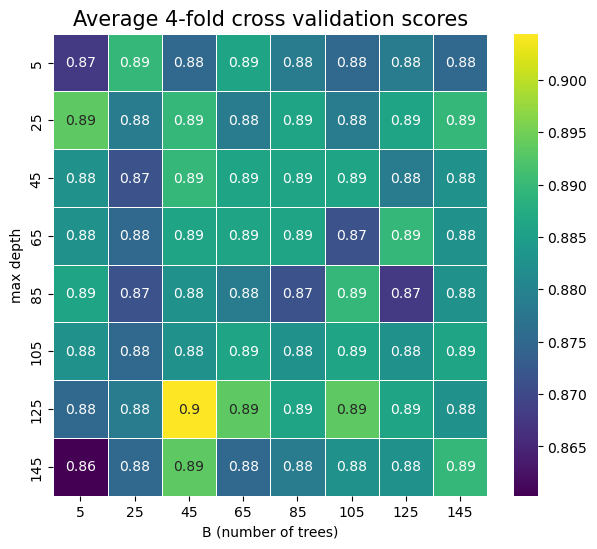

In [79]:
# produce a heatmap
scores_arr_1_2d = np.array([score_dict["score"] for score_dict in scores_arr_1]).reshape((len(max_depth_range), len(B_range)))
scores_df = pd.DataFrame(scores_arr_1_2d, index=max_depth_range, columns=B_range)
plt.figure(figsize=(7, 6))
plt.title("Average 4-fold cross validation scores", size=15)
ax = sns.heatmap(scores_df, linewidth=0.5, annot=True, cmap="viridis")
ax.set(xlabel="B (number of trees)", ylabel="max depth")

We report the optimal hyper-parameter pair explicitely below.

In [80]:
best_score = max(scores_arr_1, key=lambda x: x["score"])
best_max_depth = best_score["max_depth"]
best_B = best_score["B"]
print(best_score)

{'max_depth': 125, 'B': 45, 'score': 0.9044117647058822}


2.1.2

In this part we shall re-train our random forest classifier using the optimal hyper-parameters found, and test its performance on our unseen test dataset.

We need to first read in our diabetes test data.

In [81]:
# load test data as pandas data frames
diabetes_data_test = pd.read_csv('./diabetes_test.csv', decimal=',')
# print shape and last 10 rows
print(diabetes_data_test.shape)
diabetes_data_test.tail(10)

(117, 15)


patient_number  cholesterol  glucose  hdl_chol  chol_hdl_ratio  age  \
107             334          224      341        33             6.8   65   
108             337          281       92        41             6.9   66   
109             339          188      174        24             7.8   66   
110             344          174      125        44             4.0   67   
111             349          236      111        82             2.9   68   
112             353          182      206        43             4.2   70   
113             360          205       83        42             4.9   72   
114             362          207       71        41             5.0   72   
115             374          209      113        65             3.2   76   
116             387          226      279        52             4.3   84   

     height  weight   bmi  systolic_bp  diastolic_bp  waist  hip  \
107      67     197  30.9          160            80     42   43   
108      62     185  33.8          158            88     48   44   
109      68     210  31.9          160            78     45   48   
110      68     198  30.1          119            72     36   43   
111      61     119  22.5          142            96     29   37   
112      69     214  31.6          158            90     45   48   
113      61     180  34.0          170            90     39   47   
114      70     180  25.8          138            88     39   40   
115      60     143  27.9          156            78     35   40   
116      60     192  37.5          144            88     41   48   

     waist_hip_ratio     diabetes  
107             0.98     Diabetes  
108             1.09  No diabetes  
109             0.94  No diabetes  
110             0.84  No diabetes  
111             0.78  No diabetes  
112             0.94     Diabetes  
113             0.83  No diabetes  
114             0.98     Diabetes  
115             0.88     Diabetes  
116             0.85     Diabetes

Let us verify that our testing data is clean.

In [82]:
print(f"Total null values = {diabetes_data_test.isnull().sum().sum()}")
print(f"Total repeated values = {diabetes_data_test.duplicated().sum()}")
print(f"Dataframe types = {diabetes_data_test.dtypes}")

Total null values = 0
Total repeated values = 0
Dataframe types = patient_number       int64
cholesterol          int64
glucose              int64
hdl_chol             int64
chol_hdl_ratio     float64
age                  int64
height               int64
weight               int64
bmi                float64
systolic_bp          int64
diastolic_bp         int64
waist                int64
hip                  int64
waist_hip_ratio    float64
diabetes            object
dtype: object


We have no null values, no repeated values, and also all of our predictors are numeric (int64 or float64). Our label classification column 'diabetes' is non-numeric, so let us verify that it is indeed binary.

In [83]:
print(f"Total classification labels = {diabetes_data_test.loc[:, 'diabetes'].nunique()}")

Total classification labels = 2


We perform the same cleaning step of setting patient_number as the index as we did before.

In [84]:
# set patient_number as dataframe index
diabetes_data_test_1 = diabetes_data_test.set_index(diabetes_data_test['patient_number']).drop(diabetes_data_test.columns[0], axis=1)

# check
diabetes_data_test_1.tail()

cholesterol  glucose  hdl_chol  chol_hdl_ratio  age  height  \
patient_number                                                                
353                     182      206        43             4.2   70      69   
360                     205       83        42             4.9   72      61   
362                     207       71        41             5.0   72      70   
374                     209      113        65             3.2   76      60   
387                     226      279        52             4.3   84      60   

                weight   bmi  systolic_bp  diastolic_bp  waist  hip  \
patient_number                                                        
353                214  31.6          158            90     45   48   
360                180  34.0          170            90     39   47   
362                180  25.8          138            88     39   40   
374                143  27.9          156            78     35   40   
387                192  37.5          144            88     41   48   

                waist_hip_ratio     diabetes  
patient_number                                
353                        0.94     Diabetes  
360                        0.83  No diabetes  
362                        0.98     Diabetes  
374                        0.88     Diabetes  
387                        0.85     Diabetes

In [85]:
# convert categorical labels to numbers
diabetes_data_test_1['diabetes'] = diabetes_data_test_1['diabetes'].map(diag_map)

# put outcome and predictors in different dataframes
y_test_diabetes = diabetes_data_test_1.loc[:, "diabetes"]
X_test_diabetes = diabetes_data_test_1.iloc[:, :-1]

# check
print(y_test_diabetes.tail())
print(X_test_diabetes.tail())

patient_number
353    1.0
360   -1.0
362    1.0
374    1.0
387    1.0
Name: diabetes, dtype: float64
                cholesterol  glucose  hdl_chol  chol_hdl_ratio  age  height  \
patient_number                                                                
353                     182      206        43             4.2   70      69   
360                     205       83        42             4.9   72      61   
362                     207       71        41             5.0   72      70   
374                     209      113        65             3.2   76      60   
387                     226      279        52             4.3   84      60   

                weight   bmi  systolic_bp  diastolic_bp  waist  hip  \
patient_number                                                        
353                214  31.6          158            90     45   48   
360                180  34.0          170            90     39   47   
362                180  25.8          138            88     3

We define functions `rf_precision`, `rf_recall`, and `rf_f_score` which use entries of the confusion matrix to calculate precision, recall, and F-score respectively of a random forest classifer on some test data.

In [86]:
def rf_precision(rf, X_test, y_test):
    """
    Use the random forest to predict the test labels, and calculate the precision of them.
    Args:
    rf: A trained random forest through train_rf function.
    X_test: np array of shape (N, D), the testing set.
    y_test: np array of shape (N, ), true labels of testing set.
    
    Returns:
    float, the precision of our random forest prediction.
    """
    # make prediction
    y_pred = predict_rf(rf, X_test)
    # map integer values to boolean
    bool_map = {1: True, -1: False}
    y_pred_bool = np.array([bool_map[label] for label in y_pred])
    y_test_bool = np.array([bool_map[label] for label in y_test])
    # calculate tp and fp
    tp = np.sum(y_test_bool & y_pred_bool)
    fp = np.sum((~y_test_bool) & y_pred_bool)
    return tp / (tp + fp)

In [87]:
def rf_recall(rf, X_test, y_test):
    """
    Use the random forest to predict the test labels, and calculate the recall of them.
    Args:
    rf: A trained random forest through train_rf function.
    X_test: np array of shape (N, D), the testing set.
    y_test: np array of shape (N, ), true labels of testing set.
    
    Returns:
    float, the recall of our random forest prediction.
    """
    # make prediction
    y_pred = predict_rf(rf, X_test)
    # map integer values to boolean
    bool_map = {1: True, -1: False}
    y_pred_bool = np.array([bool_map[label] for label in y_pred])
    y_test_bool = np.array([bool_map[label] for label in y_test])
    # calculate tp and fn
    tp = np.sum(y_test_bool & y_pred_bool)
    fn = np.sum(y_test_bool & (~y_pred_bool))
    return tp / (tp + fn)

In [88]:
def rf_f_score(rf, X_test, y_test):
    """
    Use the random forest to predict the test labels, and calculate the f-score of them.
    Args:
    rf: A trained random forest through train_rf function.
    X_test: np array of shape (N, D), the testing set.
    y_test: np array of shape (N, ), true labels of testing set.
    
    Returns:
    float, the f-score of our random forest prediction.
    """
    # calculate f-score using precision and recall functions
    precision = rf_precision(rf, X_test, y_test)
    recall = rf_recall(rf, X_test, y_test)
    return 2 * precision * recall / (precision + recall)

We will now train a random forest on our training data using our optimal $B$ and $max\_depth$ parameters, and report the scores when our unweighted random forest classifier is applied to the training and testing data, with respect to our key metrics.

In [89]:
np.random.seed(169) # makes random forest reproducible
# train unweighted random forest using optimal parameters
rf_trained = train_rf(best_B, n_features, X_train_diabetes, y_train_diabetes, columns_dict, max_depth=best_max_depth)

In [90]:
# calculate our training data performance metrics
train_rf_score = rf_score(rf_trained, X_train_diabetes.to_numpy(), y_train_diabetes.to_numpy())
train_rf_precision = rf_precision(rf_trained, X_train_diabetes.to_numpy(), y_train_diabetes.to_numpy())
train_rf_recall = rf_recall(rf_trained, X_train_diabetes.to_numpy(), y_train_diabetes.to_numpy())
train_rf_f_score = rf_f_score(rf_trained, X_train_diabetes.to_numpy(), y_train_diabetes.to_numpy())
print("training set accuracy:", train_rf_score)
print("training set precision:", train_rf_precision)
print("training set recall:", train_rf_recall)
print("training set f-score:", train_rf_f_score)

training set accuracy: 1.0
training set precision: 1.0
training set recall: 1.0
training set f-score: 1.0


In [91]:
# calculate our testing data performance metrics
test_rf_score = rf_score(rf_trained, X_test_diabetes.to_numpy(), y_test_diabetes.to_numpy())
test_rf_precision = rf_precision(rf_trained, X_test_diabetes.to_numpy(), y_test_diabetes.to_numpy())
test_rf_recall = rf_recall(rf_trained, X_test_diabetes.to_numpy(), y_test_diabetes.to_numpy())
test_rf_f_score = rf_f_score(rf_trained, X_test_diabetes.to_numpy(), y_test_diabetes.to_numpy())
print("testing set accuracy:", test_rf_score)
print("testing set precision:", test_rf_precision)
print("testing set recall:", test_rf_recall)
print("testing set f-score:", test_rf_f_score)

testing set accuracy: 0.9316239316239316
testing set precision: 0.8333333333333334
testing set recall: 0.625
testing set f-score: 0.7142857142857143


We can see that our optimised unweighted random forest gives us perfect scores in all metrics for our training datset, so let us turn our attention to the scores for our testing dataset. We can see that our scores have fallen. We notice that whilst our precision is reasonably high, our recall has fallen significantly; this implies that whilst the positive diagnosese our model made were mostly accurate, it has failed to give a positive diagnosis to many of the truly positive test patients. The F-score is a balanced score of both precision and recall, so we see that it is brought down by the poor recall (true positive rate) of our random forest classifier.

In the next part we will explore why our unweighted random forest had this kind of performance on our testing data, and try to see if we can improve our model.

2.1.3

In this part of the question we now try to analyse the training dataset to see if there is anything we can do to try and improve our random forest model, and then repeat the first two parts of this question but for this new random forest model. We will then try and compare the performance of our updated random forest model with the original model.

We show the training dataset is unbalanced by calculating the frequency of positive and negative diagnosis in our training dataset.

In [92]:
pos_diabetes_count_train = np.sum([1 for diagnosis in y_train_diabetes if diagnosis==1])
neg_diabetes_count_train = np.sum([1 for diagnosis in y_train_diabetes if diagnosis==-1])
print("frequency of positive diabetic diagnosis:", pos_diabetes_count_train)
print("frequency of negative diabetic diagnosis:", neg_diabetes_count_train)

frequency of positive diabetic diagnosis: 44
frequency of negative diabetic diagnosis: 229


The number of non-diabetic patients in our training data is over 5x as many as our diabetic patients, thus our training dataset is unbalanced.

One way we can compensate for the unbalanced data is to introduce bootstrap sampling weights, so that at each bootstrap iteration we sample with replacement from a probability distribution that gives us a sample that contains equal numbers of each diagnosis label.

We now derive the formula for the weights corresponding to samples of each label. Let $w_i$ be the bootstrap weight for diagnosis label $i$, and let $\mathbb{P}(X=c_i)$ be the sample proportion of diagnosis label $i$. In our diabetes dataset we have 2 labels so $i=1, 2$. We need $w_i$ such that:

\begin{align}
w_i \cdot \mathbb{P}(X=c_i) &= \frac{1}{2}, \quad i=1,\dots, 2,\\
\implies w_i &= \frac{1}{2} \cdot \frac{1}{\mathbb{P}(X=c_i)}\\
\implies w_i &= \frac{N_s}{2\cdot N_i}, \quad N_s=\text{total samples}, N_i=\text{number of label i samples}.
\end{align}

We can obtain our reweighted bootstrap probability distribution by passing our unbalanced sample into `get_bootstrap_weights`, which we defined earlier.

We now repeat the 4-fold cross-validation grid search to find the optimal number of decision trees $B$, and maximum tree depth $max\_depth$, however this time we will use reweighted bootstrap samples. We have done this by setting keyword argument `weighted_bootstrap=True`, which creates a weighted random forest for each training fold.

In [93]:
# begin cross-validation
scores_arr_2 = perform_cross_validation_rf(X_train_diabetes, y_train_diabetes, folds_indexes_2, B_range, max_depth_range, n_features, weighted_bootstrap=True)

starting cross validation for max_depth = 5
finished cross validation for max depth = 5
starting cross validation for max_depth = 25
finished cross validation for max depth = 25
starting cross validation for max_depth = 45
finished cross validation for max depth = 45
starting cross validation for max_depth = 65
finished cross validation for max depth = 65
starting cross validation for max_depth = 85
finished cross validation for max depth = 85
starting cross validation for max_depth = 105
finished cross validation for max depth = 105
starting cross validation for max_depth = 125
finished cross validation for max depth = 125
starting cross validation for max_depth = 145
finished cross validation for max depth = 145


Once again, we produce a heatmap to visualise our grid search.

[Text(0.5, 36.72222222222221, 'B (number of trees)'),
 Text(58.222222222222214, 0.5, 'max depth')]

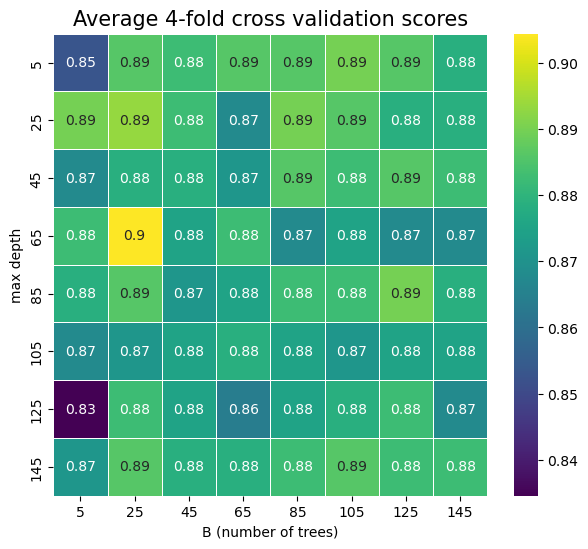

In [94]:
# produce heatmap
scores_arr_2_2d = np.array([score_dict["score"] for score_dict in scores_arr_2]).reshape((len(max_depth_range), len(B_range)))
scores_df = pd.DataFrame(scores_arr_2_2d, index=max_depth_range, columns=B_range)
plt.figure(figsize=(7, 6))
plt.title("Average 4-fold cross validation scores", size=15)
ax = sns.heatmap(scores_df, linewidth=0.5, annot=True, cmap="viridis")
ax.set(xlabel="B (number of trees)", ylabel="max depth")

We report the optimal hyper-parameter pair explicitely below for the weighted random forest.

In [95]:
best_score_weighted = max(scores_arr_2, key=lambda x: x["score"])
best_max_depth_weighted = best_score_weighted["max_depth"]
best_B_weighted = best_score_weighted["B"]
print(best_score_weighted)

{'max_depth': 65, 'B': 25, 'score': 0.9044117647058824}


Now we shall retrain our random forest using these new optimal hyper-parameters, this time using a weighted bootstrap sampling distribution. We call our function `get_bootstrap_weights` below to get our reweighted bootstrap sampling weights for our training set.

In [96]:
# calculate bootstrap weights
bootstrap_weights = get_bootstrap_weights(y_train_diabetes)

Below we retrain our random forest, passing in the bootstrap weights with keyword argument `bootstrap_weights=bootstrap-weights`.

In [97]:
np.random.seed(3269) # makes weighted random forest producible
rf_trained_weighted = train_rf(best_B_weighted, n_features, X_train_diabetes, y_train_diabetes, columns_dict, max_depth=best_max_depth_weighted, bootstrap_weights=bootstrap_weights)

Again we report the scores when applying the weighted random forest classifier to our training and also testing data, with respect to the key metrics.

In [98]:
# calculate the scoring metrics
train_rf_weighted_score = rf_score(rf_trained_weighted, X_train_diabetes.to_numpy(), y_train_diabetes.to_numpy())
train_rf_weighted_precision = rf_precision(rf_trained_weighted, X_train_diabetes.to_numpy(), y_train_diabetes.to_numpy())
train_rf_weighted_recall = rf_recall(rf_trained_weighted, X_train_diabetes.to_numpy(), y_train_diabetes.to_numpy())
train_rf_weighted_f_score = rf_f_score(rf_trained_weighted, X_train_diabetes.to_numpy(), y_train_diabetes.to_numpy())
print("weighted training set accuracy:", train_rf_weighted_score)
print("weighted training set precision:", train_rf_weighted_precision)
print("weighted training set recall:", train_rf_weighted_recall)
print("weighted training set f-score:", train_rf_weighted_f_score)

weighted training set accuracy: 1.0
weighted training set precision: 1.0
weighted training set recall: 1.0
weighted training set f-score: 1.0


In [99]:
# calculate the scoring metrics
test_rf_weighted_score = rf_score(rf_trained_weighted, X_test_diabetes.to_numpy(), y_test_diabetes.to_numpy())
test_rf_weighted_precision = rf_precision(rf_trained_weighted, X_test_diabetes.to_numpy(), y_test_diabetes.to_numpy())
test_rf_weighted_recall = rf_recall(rf_trained_weighted, X_test_diabetes.to_numpy(), y_test_diabetes.to_numpy())
test_rf_weighted_f_score = rf_f_score(rf_trained_weighted, X_test_diabetes.to_numpy(), y_test_diabetes.to_numpy())
print("weighted testing set accuracy:", test_rf_weighted_score)
print("weighted testing set precision:", test_rf_weighted_precision)
print("weighted testing set recall:", test_rf_weighted_recall)
print("weighted testing set f-score:", test_rf_weighted_f_score)

weighted testing set accuracy: 0.9316239316239316
weighted testing set precision: 0.75
weighted testing set recall: 0.75
weighted testing set f-score: 0.75


In order to compare the performance of both random forests on our testing data easier, we present their performance below in a comparison table.

In [100]:
rf_column_labels = ["train accuracy", "train precision", "train recall", "train f-score", "test accuracy", "test precision", "test recall", "test f-score"]
rf_indexes = ["unweighted rf", "weighted rf"]
rf_comparison_array = np.zeros((len(rf_indexes), len(rf_column_labels)))
rf_comparison_array[0, :] = np.array([train_rf_score, train_rf_precision, train_rf_recall, train_rf_f_score, test_rf_score, test_rf_precision, test_rf_recall, test_rf_f_score])
rf_comparison_array[1, :] = np.array([train_rf_weighted_score, train_rf_weighted_precision, train_rf_weighted_recall, train_rf_weighted_f_score, test_rf_weighted_score, test_rf_weighted_precision, test_rf_weighted_recall, test_rf_weighted_f_score])
rf_comparison_df = pd.DataFrame(rf_comparison_array, columns=rf_column_labels, index=rf_indexes)
rf_comparison_df

train accuracy  train precision  train recall  train f-score  \
unweighted rf             1.0              1.0           1.0            1.0   
weighted rf               1.0              1.0           1.0            1.0   

               test accuracy  test precision  test recall  test f-score  
unweighted rf       0.931624        0.833333        0.625      0.714286  
weighted rf         0.931624        0.750000        0.750      0.750000

Comparing the metrics for our unweighted and weighted random forests, we see that they both perform perfectly on our training data. However, on the test data, we see that the weighted random forest has a marginally better accuracy, small decrease in precision, but a reasonably large increase in recall and F-score compared to the unweighted random forest.

Our original training data was imbalanced, and so due to the smaller proportion of positive sample points in the data, our unweighted random forest classifier was biased towards the negative samples (majority) and tended to predict very few positive labels (minority) when applied to our test data, unless the confidence was very high. Out of these few positive predictions, most of these were correct and so the precision (accuracy of positive predictions) was quite high. However as a result of the model's tendency to produce negative labels rather than positive, our recall (true positive rate) was quite poor since many true positive labels are being mislabelled as negative.

On the contrary, since our weighted random forest samples more equal amounts of positive and negative points during the bootstrap step, our ensemble of decision trees in our weighted random forest has more positive data to train on, and thus have greater confidence to give out positive labels during classification on our test data (less bias towards the majority negative samples compared to our unweighted random forest). This causes our precision to drop slightly, since our weighted model hands out more positive labels, and some of these end up being mislabelled as false positives.

The F-score is a measure that combines precision and recall into a single measure that allows us to judge both properties. Ideally we would want both precision and recall to be as high as possible, but in our random forest model improving one appears to come at the cost of the other; comparing F-score allows us to judge this balance between the unweighted and weighted models. We see that our F-score is improved for our weighted random forest, and so this would suggest the tradeoff we made of worse precision for greater recall has had a positive effect on our model after applying the weighting during the bootstrap step.

We now want to plot an ROC curve and precision-recall curve. `predict_rf_probs` helps us get some threshold values, by calculating the probabilities of each label being classed as positive by the random forest classifer (proportion of decision tree classifications that are positive).

In [101]:
def predict_rf_probs(rf, X):
    """
    Predict probabilties of positive classification results for X.
    Args:
        rf: A trained random forest through train_rf function.
        X: (pd.Dataframe) testing sample features, of shape (N, D).
    Returns:
        (np.array): probabilities of predicted testing sample labels being positive, of shape (N,).
    """

    def aggregate_probs(decisions):
        count = defaultdict(int)
        for decision in decisions:
            count[decision] += 1
        return count[1]/len(decisions)

    if len(X.shape) == 1:
        return aggregate_probs([classify(tree, X) for tree in rf])
    else:
        return np.array([aggregate_probs([classify(tree, x) for tree in rf]) for x in X])

Now we have the `roc_pr_curve` function which helps calculate the information needed to produce the ROC and precision-recall curves.

In [102]:
def roc_pr_curve(y_true, y_probs):
    """
    Arguments:
    y_true: ground truth labels with size (n, )
    y_probs: probabilities produced by random forest model with size (n, )

    Returns:
    auc: area under the curve (AUC).
    tpr_l: a list of true positive rate (TPR) values for each scanned threshold.
    fpr_l: a list of false positive rate (FPR) values for each scanned threshold.
    precision_l: a list of precision values for each scanned threshold
    thresholds: the scanned thresholds sorted descendingly.
    """
    # List of distinct values in y_probs, sorted descendingly.
    thresholds = reversed(sorted(set(y_probs)))
    tpr_l, fpr_l, precision_l = [], [], []

    for threshold in thresholds:
        # Apply thresholding
        y_thresholded = (y_probs >= threshold)
        bool_map = {1: True, -1: False}
        y_true_bool = np.array([bool_map[label] for label in y_true])
        # true positives
        tp = np.sum(y_true_bool & y_thresholded)
        # true negatives
        tn = np.sum((~y_true_bool) & (~y_thresholded))
        # false positives
        fp = np.sum((~y_true_bool) & y_thresholded)
        # false negatives
        fn = np.sum(y_true_bool & (~y_thresholded))
        # true postive rate
        tpr = tp / (tp + fn)
        # false positive rate
        fpr = fp / (tn + fp)
        # precision
        precision = tp / (tp + fp)
        # append to lists
        tpr_l.append(tpr)
        fpr_l.append(fpr)
        precision_l.append(precision)

    # Compute AUC using Trapezoidal rule
    auc_roc = np.trapz(tpr_l, fpr_l)
    auc_pr = np.trapz(precision_l, tpr_l)
    return auc_roc, auc_pr, tpr_l, fpr_l, precision_l, thresholds

Let us gather the information required for the plots using our functions.

In [103]:
y_probs_unweighted = predict_rf_probs(rf_trained, X_test_diabetes.to_numpy()) # unweighted thresholds
auc_roc_unweighted, auc_pr_unweighted, tpr_unweighted, fpr_unweighted, precision_unweighted, th_unweighted = roc_pr_curve(y_test_diabetes.to_numpy(), y_probs_unweighted)

y_probs_weighted = predict_rf_probs(rf_trained_weighted, X_test_diabetes.to_numpy()) # weighted thresholds
auc_roc_weighted, auc_pr_weighted, tpr_weighted, fpr_weighted, precision_weighted, th_weighted = roc_pr_curve(y_test_diabetes.to_numpy(), y_probs_weighted)

Now let us first plot the ROC curve.

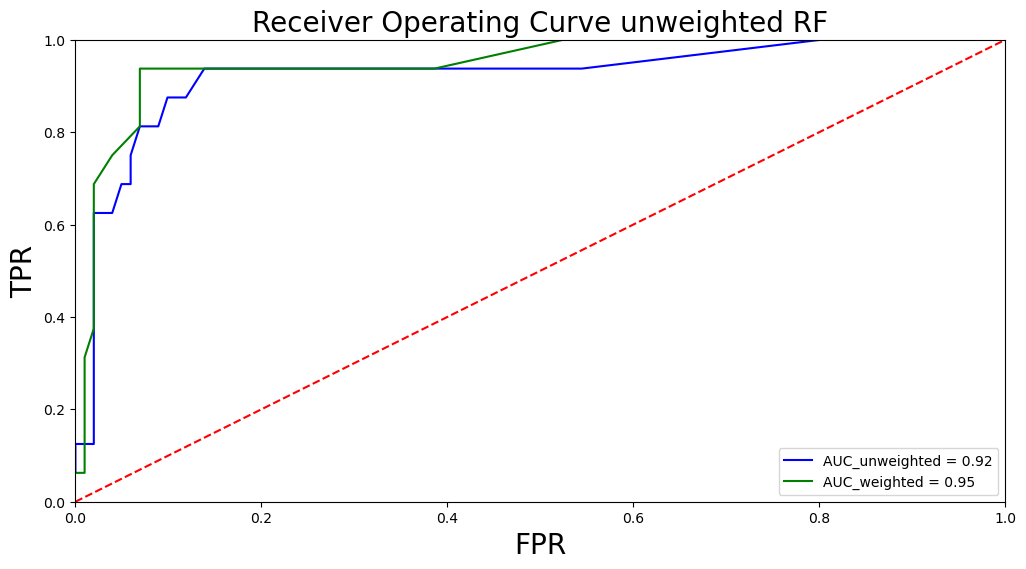

In [104]:
plt.figure(figsize=(12,6))
plt.title(f"Receiver Operating Curve unweighted RF", size=20)
plt.plot(fpr_unweighted, tpr_unweighted, 'b', label = f'AUC_unweighted = {auc_roc_unweighted:0.2f}')
plt.plot(fpr_weighted, tpr_weighted, 'g', label = f'AUC_weighted = {auc_roc_weighted:0.2f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR', size=20)
plt.xlabel('FPR', size=20)
plt.show()

From the ROC curve, we can see that both our unweighted and weighted random forests look to be performing very well, as they both lie very close to the upper left corner (0, 1) which is a perfect classification of the test samples. They are clearly both much more effective than a completely random classifier denoted by the red line. However, more precisely in terms of AUC, our weighted random forest has a higher AUC than the unweighted random forest, which suggests our reweighting has been successful in helping the classifier distinguish between diabetic and non-diabetic patients.

Now let us plot the precision-recall curve.

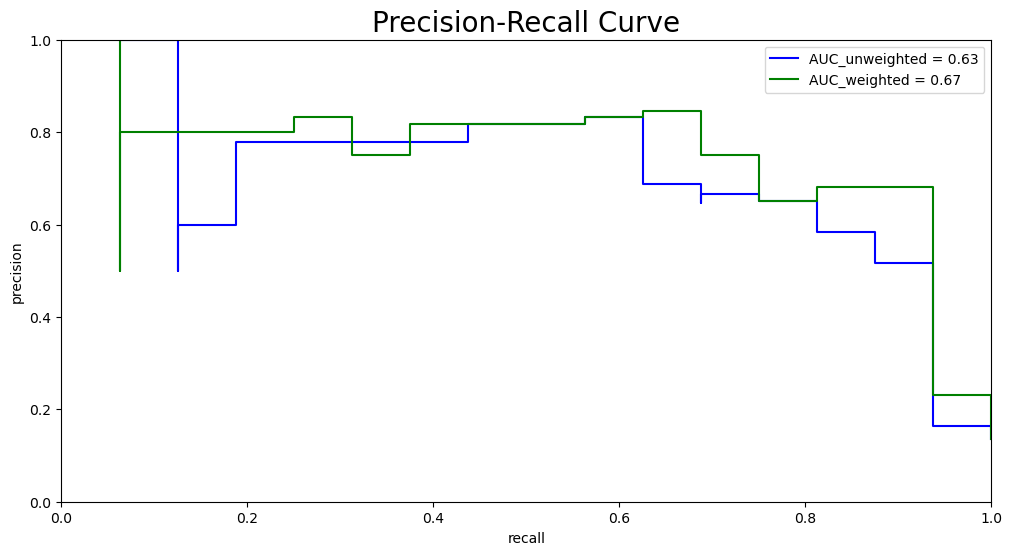

In [105]:
plt.figure(figsize=(12,6))
plt.title("Precision-Recall Curve", size=20)
plt.step(tpr_unweighted, precision_unweighted, 'b', label = f"AUC_unweighted = {auc_pr_unweighted:0.2f}")
plt.step(tpr_weighted, precision_weighted, 'g', label = f"AUC_weighted = {auc_pr_weighted:0.2f}")
plt.legend()
plt.xlabel("recall")
plt.ylabel("precision")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

From our precision-recall graph, we see that they have very similar shape, however our weighted random forest precision-recall curve appears to almost always lie above that of the unweighted random forest, which is reflected in our larger AUC for the weighted version. This suggests that in terms of precision-recall balance, our weighted random forest is an improvement over the unweighted as we had predicted from observing the difference in F-scores.

#### 2.2	Support Vector Machine (SVM) (30 marks)
2.2.1

Now we explore a new type of classification method, Support Vector Machines. In this first part we will try and train a soft-margin linear SVM using stochastic gradient descent, and use 4-fold cross-validation to try and optimise our hardness hyper-parameter $\lambda$.

Our soft-margin linear SVM clasifier has loss function is given by: \begin{align}
L_{LSVM} &=  \frac{1}{2}\|\boldsymbol w\|^2 + \lambda \sum_{i=1}^N \rm{max}\left\{0, 1-y^{(i)}\left(\boldsymbol x^{(i)} \cdot \boldsymbol w + b\right)\right\}.\end{align}

The goal of a linear SVM classifier is to fully separate our two class labels into two regions by a single hyperplane.

However, it is often not possible to separate the classes linearly with 100% accuracy, and so we use a soft-margin SVM classifier to relax the conditions. The hinge loss function $\rm{max}\left\{0, 1-y^{(i)}\left(\boldsymbol x^{(i)} \cdot \boldsymbol w + b\right)\right\}$ in the sum term of our loss function is used to penalise imperfect classifications of our hyperplane, as it takes value 0 when $y_i$ is classified correctly, or otherwise given by the size of the violation if incorrectly classified. The hardness hyper-parameter $\lambda$ controls how much we penalise the incorrect classifications, with our optimisation being equivalent to a stricter hard-margin SVM classifier as we take the limit to infinity.

We try and minimise our loss function by implementing stochastic gradient descent, which is very similar to the gradient descent method, except it doesn't calculate the gradient exactly, but rather estimates it by taking the average of the gradient for a subset of our data (a batch).

Note also that our loss function above is convex, since the hinge loss function is convex and we know the first term also is convex. Thus, we should converge to the optimal $\boldsymbol w$ when we use our stochastic gradient method.

The function `compute_cost_SVM` helps us compute our cost function, which we need in our stopping criteria for our stochastic gradient descent algorithm.

In [106]:
def compute_cost_SVM(w, X, y, regul_strength=1e5):
    """
    Compute cost function of linear SVM.
    Args:
    w: weights array of size (D+1, ), corresponding to the normal of hyperplane in SVM.
    X: np array of shape (N, D+1), the data matrix.
    y: np array of shape (N, ), true labels corresponding to the data matrix.
    
    Returns:
    float, the cost function evaluated.
    """
    n = X.shape[0]
    distances = 1 - y * (X @ w)  
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge = regul_strength * distances.mean() 

    # calculate cost
    return 0.5 * np.dot(w, w) + hinge -0.5*w[-1]**2

We now derive the gradients of the loss function with respect to $\boldsymbol w$ and $b$, which are required in the update step of our stochastic gradient descent:

\begin{align}
\frac{\partial L_{LSVM}}{\partial \boldsymbol w} &= \boldsymbol w + \lambda \sum_{i=1}^N \mathbb{I}(y^{(i)}, \boldsymbol x^{(i)}, \boldsymbol w, b)(-y^{(i)}\boldsymbol x^{(i)}),\\
\frac{\partial L_{LSVM}}{\partial b} &= \lambda \sum_{i=1}^N \mathbb{I}(y^{(i)}, \boldsymbol x^{(i)}, \boldsymbol w, b)(-y^{(i)})
\end{align}

where we define $\mathbb{I}(y^{(i)}, \boldsymbol x^{(i)}, \boldsymbol w, b) = \begin{cases}1 &  \text{if } 1-y^{(i)}\left(\boldsymbol x^{(i)} \cdot \boldsymbol w + b\right) > 0, \\
0 & \text{otherwise}.\end{cases}$

Our function `calculate_cost_gradient_SVM` calculates the average gradient of the cost function after being supplied a batch of data.

In [107]:
def calculate_cost_gradient_SVM(w, X_batch, y_batch, regul_strength=1e6):
    """
    Find the average gradient of cost function w.r.t. w for a batch of X, y.
    Args:
    w: weights array of size (D+1, ), corresponding to the normal of hyperplane in SVM.
    X_batch: array of size (k, D+1), a subset of the entire data matrix.
    y_batch: array of size (k, ), a subset of the true labels corresponding to the data matrix
    regul_strength: float, the hardness parameter lambda.
    
    Returns:
    average gradient of cost function, an array of size (D+1, )
    """
    # if only one example is passed
    if type(y_batch) == np.float64:
        y_batch = np.asarray([y_batch])
        X_batch = np.asarray([X_batch])  # gives multidimensional array

    distance = 1 - (y_batch * (X_batch @ w))
    dw = np.zeros(len(w))
  
    we = w.copy() # So as not to overwrite w
    we[-1] = 0 # So as not to have b in its derivative when adding the weights in di

    for ind, d in enumerate(distance):
        if max(0, d)==0:
            di = we # derivative of first term
        else:
            di = we - (regul_strength * y_batch[ind] * X_batch[ind])
        dw += di

    return dw/len(y_batch)  # average

Now we implement a function `sgd_SVM` that performs our stochastic gradient descent, where we update the weights at each iteration according to:
\begin{align}
\boldsymbol w &= \boldsymbol w - \alpha \left\{\frac{\partial L_{LSVM}}{\partial \boldsymbol w}\right\}_{batch},\\
b &= b - \alpha \left\{\frac{\partial L_{LSVM}}{\partial b}\right\}_{batch}, \quad \alpha = \text{learning rate}.
\end{align}
Note that for this linear SVM we can append our data matrix with a column of ones so that it trains the intercept appropriately, since the last entry of $\boldsymbol x^{(i)}$ in the sum term will be 1 when we use this augmented data matrix. This gives us an augmented $\boldsymbol w$ with the intercept as the last entry.

For our convergence criteria, we end the iterations if the absolute fractional change in cost of every $2^{n}$th iteration is less than a certain threshold, given by keyword argument $stop\_criterion$.

In [108]:
def sgd_SVM(X, y, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-5, regul_strength=1e6, print_outcome=False):
    """
    Perform stochastic gradient descent to find the optimal weights.
    Args:
    X: np array of shape (N, D+1), the data matrix.
    y: np array of shape (N, ), true labels corresponding to the data matrix.
    max_iterations: maximum number of iterations to run.
    stop_criterion: float, parameter to change the tolerance of convergence in stopping criteria.
    learning_rate: float, parameter to change the step size of descent.
    regul_strength: float, the hardness parameter lambda.
    print_outcome: bool, determine whether to print iteration number and cost.
    
    Returns:
    w: weights array of size (D+1, ), corresponding to the normal of hyperplane in SVM.
    """
    # initialise zero weights
    weights = np.zeros(X.shape[1])
    nth = 0
    # initialise starting cost as infinity
    prev_cost = np.inf

    # stochastic gradient descent
    indices = np.arange(len(y))

    for iteration in range(1, max_iterations):
        # shuffle to prevent repeating update cycles
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]
    
        for xi, yi in zip(X, y):
            descent = calculate_cost_gradient_SVM(weights, xi, yi, regul_strength) 
            weights = weights - (learning_rate * descent)

        # convergence check on 2^n'th iteration
        if iteration==2**nth or iteration==max_iterations-1:
            # compute cost
            cost = compute_cost_SVM(weights, X, y, regul_strength)  
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))
            # stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return weights

            prev_cost = cost
            nth += 1
    print("max iterations exceeded")
    return weights

We prepare our training data for a soft-margin linear SVM classifier below. It makes sense to standardise the training data since the predictors take values over different ranges, and we are working with distances in SVM.

We add a column of ones to the end so that our linear SVM trains the intercept.

In [109]:
# standardise training data
mu_train_diabetes = np.mean(X_train_diabetes, 0)
sigma_train_diabetes = np.std(X_train_diabetes, 0)
X_train_diabetes_std = (X_train_diabetes - mu_train_diabetes) / sigma_train_diabetes

# standardise test data by same transformation as train
X_test_diabetes_std = (X_test_diabetes - mu_train_diabetes) / sigma_train_diabetes
# insert 1 in every row for intercept b
X_train_diabetes_svd_intercept = np.hstack((X_train_diabetes_std, np.ones((len(X_train_diabetes_std),1)) ))
X_test_diabetes_svd_intercept = np.hstack((X_test_diabetes_std, np.ones((len(X_test_diabetes_std),1)) ))

Given data matrix $\boldsymbol X$ and trained weights $\boldsymbol w$, we can make a classification prediction by evaluating the sign of the entries of $\boldsymbol X \cdot \boldsymbol w$. We use this in our `score_SVM` function.

In [110]:
def score_SVM(w, X, y):
    """
    Make classification prediction using weights, and calculate the accuracy of prediction.
    Args:
    w: weights array of size (D+1, ), corresponding to the normal of hyperplane in SVM.
    X: np array of shape (N, D+1), the data matrix.
    y: np array of shape (N, ), true labels corresponding to the data matrix.
    Returns:
    float, accuracy of prediction.
    """
    y_preds = np.sign(X @ w)
    return np.mean(y_preds==y)

Like all other cross-validations we have done, we define `cross_validation_score_SVM` to calculate the average accuracy score for a particular regularisation strength $\lambda$.

The parameters $max\_iterations=50000, stop\_criterion=0.01,$ and  $learning\_rate=10^{-8},$ have all been chosen thoughtfully by observing the cost function so that we get convergence of our stochastic gradient descent.

In [111]:
def cross_validation_score_SVM(X_train, y_train, folds, regul_strength=1e5):
    """
    Calculate the average accuracy of linear SVM classifier over T-fold cross-validation.
    Args:
    X_train: train predictor data of size (n, d), where d is the number of predictors.
    y_train: outcome data of size (n, 1) associated with the train predictor data.
    folds: An T-size array of arrays containing the indexes of each fold.
    regul_strength: float, the hardness parameter lambda.
    
    Returns:
    Average accuracy of random forests during cross-validation, a float.
    """
    scores = []

    for i in range(len(folds)):
        val_indexes = folds[i] # get validation fold indexes
        # get training fold indexes
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))

        # split data into training and validation folds
        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]


        X_val_i = X_train[val_indexes, :]
        y_val_i = y_train[val_indexes]
        
        # train the model
        w = sgd_SVM(X_train_i, y_train_i, max_iterations=50000, stop_criterion=0.01, learning_rate=1e-8, regul_strength=regul_strength, print_outcome=False)
        score_i = score_SVM(w, X_val_i, y_val_i)
        # append the score
        scores.append(score_i)

    # Return the average score
    return np.mean(scores)

Now let us define `perform_cross_validation_SVM` to help us perform 4-fold cross-validation for a given range of $\lambda$.

In [112]:
def perform_cross_validation_SVM(X_train, y_train, folds, regul_strength_range):
    """
    Perform T-fold cross-validation across regul_strengths in regul_strength_range.
    Args:
    X_train: train predictor data of size (n, d), where d is the number of predictors.
    y_train: outcome data of size (n, 1) associated with the train predictor data.
    folds: An T-size array of arrays containing the indexes of each fold.
    regul_strength_range: range of floats, the range of hardness parameters lambda.
    
    Returns:
    cross_val_scores: a dict, with keys in regul_strength_range which map to the score corresponding
    to that regul_strength.
    """
    # initialise the dict
    cross_val_scores = {}
    print("starting cross validation")
    for regul_strength in regul_strength_range:
        # map the regul_strength to the score in dict
        score = cross_validation_score_SVM(X_train, y_train, folds, regul_strength=regul_strength)
        cross_val_scores[regul_strength] = score
    print("finished cross validation")
    return cross_val_scores

We will perform our 4-fold cross-validation with $\lambda = 10^k$, for $k=0,\dots,6$.

In [140]:
# define range of lambda
lambda_range = np.array([10**x for x in range(0, 7)])
cross_val_scores_SVM = perform_cross_validation_SVM(X_train_diabetes_svd_intercept, y_train_diabetes.to_numpy(), folds_indexes_2, lambda_range)

starting cross validation
finished cross validation


We now plot our average accuracy against $\lambda$ on a log-10 scale.

Text(0, 0.5, 'cross validation score')

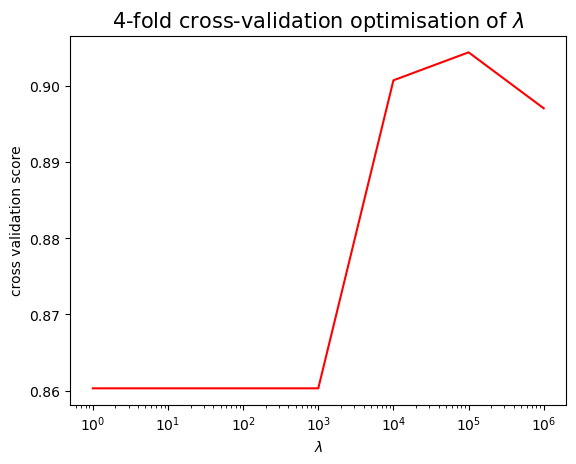

In [141]:
plt.figure()
plt.plot(cross_val_scores_SVM.keys(), cross_val_scores_SVM.values(), "r-")
plt.title(r"4-fold cross-validation optimisation of $\lambda$", fontsize=15)
plt.xlabel(r'$\lambda$')
plt.xscale("log")
plt.ylabel("cross validation score")

We report the optimal $\lambda$ and its average 4-fold cross-validation score below.

In [142]:
optimal_lambda_SVM = max(cross_val_scores_SVM, key=cross_val_scores_SVM.get)
print("optimal lambda:", optimal_lambda_SVM, ", score:", cross_val_scores_SVM[optimal_lambda_SVM])

optimal lambda: 100000 , score: 0.9044117647058822


From our graph, we see that the lower limits of $\lambda$, we see the worst performance with around 86% average cross-validation accuracy. Increasing $\lambda$ by fators of 10 does not appear to give any noticible improvement until we reach $\lambda=10^3$, following which we begin to get a steep increase in our cross-validation scores as $\lambda$ increases to $\lambda=10^4$. We see that after reaching our optimal $\lambda=10^5$, our scores then appear to drop as we increase $\lambda$ by another factor of 10.

It appears that the hyper-parameter $\lambda$ must be increased to a certain level/threshold (around $10^3$) before it can start to have an effect on our linear SVM, which is likely explained by the fact in the loss function $\lambda$ must be at a large enough to actually be effective in forcing the size of violations to be small; small $\lambda$'s will not be very aggressive. Once we are past this threshold, we notice improvement in performance as we increase $\lambda$ until we reach our optimal value, as our linear SVM becomes harder and less tolerant of misclassifications. However, the drop in performance after the optimal illustrates the fact that our SVM is now becoming too strict, as we converge to a hard-margin linear SVM when $\lambda$ goes to $\infty$; the point of soft-margin SVM is to have some optimal tolerance for misclassification so that we produce the most accurate split overall.

Our findings would suggest that the hardness hyper-parameter is something that should be tuned to a value not too big, but also not too small in order to maximise performance of the linear SVM classifier, and obviously this is going to be different for different training datasets.

2.2.2

The next task is to find the optimal hyperplanes for each $\lambda$ we scanned over in our cross-validation, and report the cosine of the angle between each pair of hyperplanes. We describe below how we can do this by finding the weights $\boldsymbol w$ for each hyperplane.

Using stochastic gradient descent we obtain a vector of weights $\boldsymbol w$, which is a normal vector to the hyperplane. Finding the cosine of the angle between two normal vectors of hyperplanes is equivalent to finding the cosine of the angle between the hyperplanes themselves, so we can use the two normal vectors corresponding to the two hyperplanes $\boldsymbol w_1$, $\boldsymbol w_2$:
\begin{align}
\cos\left(\theta_{\boldsymbol w_1, \boldsymbol w_2}\right) &= \frac{\boldsymbol w_1^T \boldsymbol w_2}{\|\boldsymbol w_1\| \|\boldsymbol w_2\|},\\
&= \hat{\boldsymbol w_1}^T \hat{\boldsymbol w_2}, \quad \text{where $\hat{\boldsymbol w_1}$, $\hat{\boldsymbol w_2}$ are unit normal vectors.}
\end{align}

We can get the matrix of all cosine of angle between all weight vector pairs by forming a matrix $\boldsymbol W$, whose rows correspond to the normalised weight vectors, and right-multiplying by the tranpose:
\begin{align}
\boldsymbol W \boldsymbol W^T &= \begin{bmatrix}\hat{\boldsymbol w_1}^T \\ \hat{\boldsymbol w_2}^T \\ \vdots \\ \hat{\boldsymbol w_n}^T\end{bmatrix}\begin{bmatrix}\hat{\boldsymbol w_1}^T \\ \hat{\boldsymbol w_2}^T \\ \vdots \\ \hat{\boldsymbol w_n}^T\end{bmatrix}^T\\
&= \begin{bmatrix}\hat{\boldsymbol w_1}^T \\ \hat{\boldsymbol w_2}^T \\ \vdots \\ \hat{\boldsymbol w_n}^T\end{bmatrix}\begin{bmatrix}\hat{\boldsymbol w_1} & \hat{\boldsymbol w_2} & \dots & \hat{\boldsymbol w_n}\end{bmatrix}
&= \begin{bmatrix}\hat{\boldsymbol w_1}^T\hat{\boldsymbol w_1} & \dots & \hat{\boldsymbol w_1}^T\hat{\boldsymbol w_n}
\\ \vdots & & \vdots \\ \hat{\boldsymbol w_n}^T\hat{\boldsymbol w_1} & \dots & \hat{\boldsymbol w_n}^T\hat{\boldsymbol w_n}\end{bmatrix}\\
&= \begin{bmatrix}
\cos\left(\theta_{\boldsymbol w_1, \boldsymbol w_1}\right) & \dots & \cos\left(\theta_{\boldsymbol w_1, \boldsymbol w_n}\right)
\\ \vdots & & \vdots \\ \cos\left(\theta_{\boldsymbol w_n, \boldsymbol w_1}\right) & \dots & \cos\left(\theta_{\boldsymbol w_n, \boldsymbol w_n}\right)\end{bmatrix}
\end{align}

`get_cos_angle_pairs` implements the formula described above to get an array of every inner product between the weight vector pairs.

In [143]:
def get_cos_angle_pairs(X_train, y_train, regul_strength_list):
    """
    Calculate the cosine of the angle between each pair of hyperplanes trained for each pair of lambdas.
    Args:
    X_train: train predictor data of size (n, d), where d is the number of predictors.
    y_train: outcome data of size (n, 1) associated with the train predictor data.
    regul_strength_list: a list of size (k, ) of all the hardness parameters lambda.
    
    Returns:
    A (k, k) array of cosine angles, as defined above.
    """
    cos_angle_array = np.zeros((len(regul_strength_list), len(regul_strength_list)))
    w_array = np.array([sgd_SVM(X_train, y_train, max_iterations=50000, stop_criterion=0.01, learning_rate=1e-8, regul_strength=regul_strength) for regul_strength in regul_strength_list])
    # normalise each row 
    w_array_norm = np.array([w_array[idx, :]/np.linalg.norm(w_array[idx, :]) for idx in range(w_array.shape[0])])
    w_cos_angle_array = w_array_norm @ w_array_norm.T
    return w_cos_angle_array

Let us generate the cosine angle pairs and plot them in a heatmap below.

In [144]:
cos_angle_pairs = get_cos_angle_pairs(X_train_diabetes_svd_intercept, y_train_diabetes.to_numpy(), lambda_range)

[Text(0.5, 36.72222222222221, '$\\lambda$'),
 Text(58.222222222222214, 0.5, '$\\lambda$')]

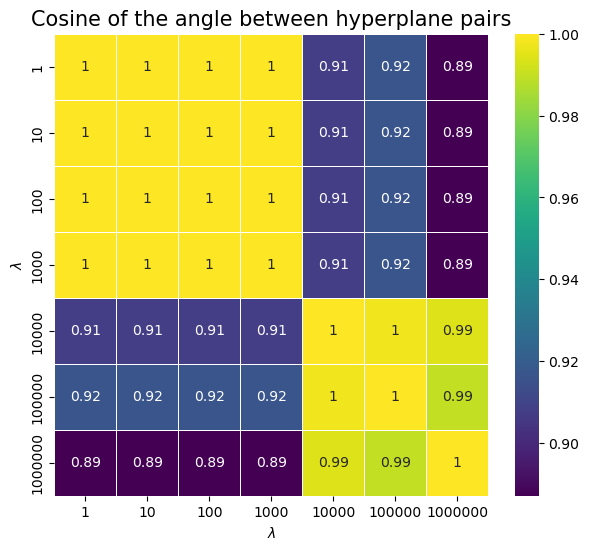

In [145]:
cos_angle_pairs_df = pd.DataFrame(cos_angle_pairs, index=lambda_range, columns=lambda_range)
plt.figure(figsize=(7,6))
plt.title("Cosine of the angle between hyperplane pairs", size=15)
ax = sns.heatmap(cos_angle_pairs_df, linewidth=0.5, annot=True, cmap="viridis")
ax.set(xlabel=r'$\lambda$', ylabel=r'$\lambda$')

We notice that the cosine of the angle between hyperplanes corresponding to $\lambda \leq 10^3$ appear to all be 1, which suggests that these hyperplanes are being parallel. This seems to agree with what we saw in terms of our cross-validation curve, where the average accuracy did not change very much for these $\lambda$'s; it is likely that because our hardness parameter is not large enough yet to be effective, we are getting very similar, if not the same, hyperplanes for these values.

We notice a similar trend in the cosine of the angle between hyperplanes for $\lambda > 10^3$, which are also close to 1 so again the hyperplanes are likely not too skewed (close to being parallel). However, we do notice slight changes in value (shade differences) of cosine angle between consecutive hyperplane pairs, which suggests that our hyperplanes are indeed slightly shifting in their geometry; we see that this is reflected in the slight performance changes from our previous cross-validation graph.

The cosine of the angle between a hyperplane where $\lambda \leq 10^3$ and a hyperplane where $\lambda > 10^3$ appears to be closer to 0.9, which suggests that in this case our hyperplanes are much more skewed/less parallel. This suggests that once our $\lambda$ is big enough to start significantly penalising the violations, it causes some rotations in our hyperplane; this corresponds to the steep increase in cross-validation accuracy we saw before.

2.2.3

We now retrain our linear SVM on the entire training set with hyper-parameter set as the optimal $\lambda$ found above.

In [146]:
w_optimal = sgd_SVM(X_train_diabetes_svd_intercept, y_train_diabetes.to_numpy(), max_iterations=10000, stop_criterion=0.01, learning_rate=1e-8, regul_strength=optimal_lambda_SVM)

Define `precision_SVM`, `recall_SVM`, and `f_score_SVM` to calculate the precision, recall, and F-score for test data classified by a linear SVM weights.

In [147]:
def precision_SVM(w, X_test, y_test):
    """
    Use the weights to predict the test labels, and calculate the precision of them.
    Args:
    w: weights array of size (D+1, ), corresponding to the normal of hyperplane in SVM.
    X_test: np array of shape (N, D+1), the testing set.
    y_test: np array of shape (N, ), true labels of testing set.
    
    Returns:
    float, the precision of our linear SVM classifier.
    """
    # make prediction
    y_pred = np.sign(X_test @ w)
    # convert prediction and test to booleans
    bool_map = {1: True, -1: False}
    y_pred_bool = np.array([bool_map[label] for label in y_pred])
    y_test_bool = np.array([bool_map[label] for label in y_test])
    # calculate tp and fp
    tp = np.sum(y_test_bool & y_pred_bool)
    fp = np.sum((~y_test_bool) & y_pred_bool)
    return tp / (tp + fp)

In [148]:
def recall_SVM(w, X_test, y_test):
    """
    Use the weights to predict the test labels, and calculate the recall of them.
    Args:
    w: weights array of size (D+1, ), corresponding to the normal of hyperplane in SVM.
    X_test: np array of shape (N, D+1), the testing set.
    y_test: np array of shape (N, ), true labels of testing set.
    
    Returns:
    float, the recall of our linear SVM classifier.
    """
    # make prediction
    y_pred = np.sign(X_test @ w)
    # convert prediction and test to booleans
    bool_map = {1: True, -1: False}
    y_pred_bool = np.array([bool_map[label] for label in y_pred])
    y_test_bool = np.array([bool_map[label] for label in y_test])
    # calculate tp and fn
    tp = np.sum(y_test_bool & y_pred_bool)
    fn = np.sum(y_test_bool & (~y_pred_bool))
    return tp / (tp + fn)

In [149]:
def f_score_SVM(w, X_test, y_test):
    """
    Use the weights to predict the test labels, and calculate the f-score of them.
    Args:
    w: weights array of size (D+1, ), corresponding to the normal of hyperplane in SVM.
    X_test: np array of shape (N, D+1), the testing set.
    y_test: np array of shape (N, ), true labels of testing set.
    
    Returns:
    float, the f-score of our linear SVM classifier.
    """
    # calculate f-score using precision and recall functions
    precision = precision_SVM(w, X_test, y_test)
    recall = recall_SVM(w, X_test, y_test)
    return 2 * precision * recall / (precision + recall)

We now report the out-of-sample scoring metrics.

In [150]:
test_SVM_score = score_SVM(w_optimal, X_test_diabetes_svd_intercept, y_test_diabetes.to_numpy())
test_SVM_precision = precision_SVM(w_optimal, X_test_diabetes_svd_intercept, y_test_diabetes.to_numpy())
test_SVM_f_score = f_score_SVM(w_optimal, X_test_diabetes_svd_intercept, y_test_diabetes.to_numpy())
print("testing set accuracy:", test_SVM_score)
print("testing set precision:", test_SVM_precision)
print("testing set f-score:", test_SVM_f_score)

testing set accuracy: 0.9316239316239316
testing set precision: 0.8333333333333334
testing set f-score: 0.7142857142857143


These scores will be used for comparison in the next part using a kernelised SVM classifier.

2.2.4

Now, we shall implement our kernelised SVM which allows us to implement a non-linear hyper-plane divider.

Our soft-margin kernelised SVM clasifier has loss function is given by: \begin{align}
L_{KSVM} &=  \frac{1}{2}\boldsymbol u^T \boldsymbol K \boldsymbol u + \lambda \sum_{i=1}^N \rm{max}\left\{0, 1-y^{(i)}\left(\boldsymbol K^{(i)} \cdot \boldsymbol u + b\right)\right\},\end{align}
with $[\boldsymbol K]_{ij} = \rm tanh\left(\sigma (\boldsymbol x_i \cdot \boldsymbol x_j) + 1\right)$, the $sigmoid$ kernel.

The sum of hinge-loss functions in the second term behaves in the same way as a penalisation for improper classification, and we again aim to minimise this loss function to get our optimal weights $\boldsymbol u$.

However, one key thing to note now is that our sigmoid kernel matrix is not necessarily positive definite, and so our loss function may not be convex, i.e. the minima we converge to via stochastic gradient descent may not be a global minimum. This is just something we should bare in mind when evaluate our kernelised SVM classifier.

We first define a function `kernel_matrix` that finds the sigmoid function kernel matrix for given data.

In [151]:
# First we need a function to calculate the kernel given the data #
def kernel_matrix(X1,X2, sigma):
    """
    Find the kernel matrix given the data.
    Args:
    X1: np array of size (n1, m) containing data on its rows.
    X2: np array of size (n2, m) containing data on its rows.
    sigma: float, parameter of the sigmoid kernel.
    
    Returns:
    kernel: np array of size (m, m), i,jth entry corresponding to the kernel between row i of X1 and row j of X2.
    """
    # Here we define a Sigmoid Function Kernel #
    kernel = np.tanh(sigma * (X1 @ X2.T) + 1)
    return kernel

The function `compute_cost_kernel` helps us compute our cost function, which we need in our stopping criteria for our stochastic gradient descent algorithm.

In [152]:
def compute_cost_kernel(u, K, y, regul_strength=1e3,intercept=0):
    """
    Compute the cost function for the kernel SVM classifier.
    Args:
    u: weights array of size (D, ).
    K: kernel matrix array of size (D, D).
    y: label array of size (N, )
    regul_strength: float, the hardness parameter lambda
    """
    # Here I define the hinge cost with the kernel trick. NB: the intercept should be kept separate #
    
    distances = 1 - (y)*(K@u + intercept) 
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge = regul_strength * distances.mean()

    # calculate cost
    return 0.5 * np.dot(u,K@u) + hinge

We now derive the gradients of the loss function with respect to $\boldsymbol u$ and $b$, which are required in the update step of our stochastic gradient descent:

\begin{align}
\frac{\partial L_{KSVM}}{\partial \boldsymbol u} &= \boldsymbol K \boldsymbol u + \lambda \sum_{i=1}^N \mathbb{I}(y^{(i)}, \boldsymbol K^{(i)}, \boldsymbol u, b)(-y^{(i)}\boldsymbol K^{(i)}),\\
\frac{\partial L_{KSVM}}{\partial b} &= \lambda \sum_{i=1}^N \mathbb{I}(y^{(i)}, \boldsymbol K^{(i)}, \boldsymbol u, b)(-y^{(i)})
\end{align}

where we define $\mathbb{I}(y^{(i)}, \boldsymbol K^{(i)}, \boldsymbol u, b) = \begin{cases}1 &  \text{if } 1-y^{(i)}\left(\boldsymbol K^{(i)} \cdot \boldsymbol u + b\right) > 0, \\
0 & \text{otherwise}.\end{cases}$

Our function `calculate_cost_gradient_kernel` calculates the average gradient of the cost function after being supplied a batch of data.

In [153]:
def calculate_cost_gradient_kernel(u, K_batch, y_batch, regul_strength=1e3,intercept=0):
    """
    Find the average gradient of cost function w.r.t. u and intercept for a batch of K, y.
    Args:
    u: weights array of size (D, ).
    K_batch: array of size (k, D), a subset of the entire kernel matrix.
    y_batch: array of size (k, ), a subset of the true labels corresponding to the data matrix.
    regul_strength: float, the hardness parameter lambda.
    intercept: float, the intercept term.
    
    Returns:
    average gradient of cost function with respect to u, an array of size (D, ).
    average gradient of cost function with respect to b, a float.
    """
    # if only one example is passed
    if type(y_batch) == np.float64 or type(y_batch) == np.int32:
        y_batch = np.asarray([y_batch])
        K_batch = np.asarray([K_batch])  # gives multidimensional array
    
    distance = 1 - (y_batch * (K_batch @ u + intercept)) 
    dw = np.zeros(len(u))
    
    db = 0

    # define the gradient with the hinge loss #
    for ind, d in enumerate(distance):
        if max(0, d)==0:
            di = K_batch@u 
            
        else:
            di = K_batch@u - (regul_strength * y_batch[ind] * K_batch[ind]) 
            db -= regul_strength * y_batch[ind]
        dw += di
    return dw/len(y_batch), db/len(y_batch)

Now we implement a function `sgd_kernel` that performs our stochastic gradient descent, where we update the weights at each iteration according to:
\begin{align}
\boldsymbol u &= \boldsymbol u - \alpha \left\{\frac{\partial L_{KSVM}}{\partial \boldsymbol u}\right\}_{batch},\\
b &= b - \alpha \left\{\frac{\partial L_{KSVM}}{\partial b}\right\}_{batch}, \quad \alpha = \text{learning rate}.
\end{align}

Note that for this kernel SVM we train the intercept term $b$ and the weights $\boldsymbol u$ separately in our stochastic gradient descent function `sgd_kernel`.

For our convergence criteria, we end the iterations if the absolute fractional change in cost of every 1000'th iteration is less than a certain threshold, given by keyword argument $stop\_criterion$.

In [154]:
def sgd_kernel(K, y, batch_size=32, max_iterations=4000, stop_criterion=0.001, learning_rate=1e-4, regul_strength=1e3, print_outcome=False):
    """
    Perform stochastic gradient descent to find the optimal weights and intercept.
    Args:
    K: np array of shape (D, D), the kernel matrix.
    y: np array of shape (N, ), true labels corresponding to the data matrix.
    batch_size: batch size to pass into the calculate_cost_gradient_kernel.
    max_iterations: maximum number of iterations to run.
    stop_criterion: float, parameter to change the tolerance of convergence in stopping criteria.
    learning_rate: float, parameter to change the step size of descent.
    regul_strength: float, the hardness parameter lambda.
    print_outcome: bool, determine whether to print iteration number and cost.
    
    Returns:
    u: weights array of size (D+1, ).
    intecept: the intercept of the hyperplane.
    """
    # initialise zero u and intercept
    u = np.zeros(K.shape[1])
    intercept=0
    
    nth = 0
    # initialise starting cost as infinity
    prev_cost = np.inf
    
    # stochastic gradient descent
    indices = np.arange(len(y))
    for iteration in range(1, max_iterations):
        # shuffle to prevent repeating update cycles
        np.random.shuffle(indices)
        batch_idx = indices[:batch_size]
        K_b, y_b = K[batch_idx], y[batch_idx]
        for ki, yi in zip(K_b, y_b):
            ascent, db = calculate_cost_gradient_kernel(u, ki, yi, regul_strength, intercept)
            u = u - (learning_rate * ascent)
            
            # train intercept
            intercept = intercept - (learning_rate * db)
        
        # convergence check on 2^n'th iteration
        if iteration % 100 == 0 or iteration==max_iterations-1:
            # compute cost
            cost = compute_cost_kernel(u, K, y, regul_strength, intercept)
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))
            # stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return u, intercept
            
            prev_cost = cost
            nth += 1
    print("max iterations exceeded")
    return u, intercept

Now we have implemented our stochastic gradient descent function, we fix our hardness parameter to $\lambda=10$, and train our kernel SVM for $\sigma \in \{0.01, 0.1, 1, 2\}$, explicitely printing the trained intercept term.

Once again we have chosen our parameters $batch\_size=150, max\_iterations=10000, stop\_criterion=0.005,$ and $learning\_rate=10^{-6}$ very thoughtfully to ensure convergence by observing the behaviour of the cost function.

In [155]:
reg=10
for sigma in [0.01, 0.1, 1, 2]:
    K_train = kernel_matrix(X_train_diabetes_std.to_numpy(), X_train_diabetes_std.to_numpy(), sigma)
    u,b = sgd_kernel(K_train, y_train_diabetes.to_numpy(), batch_size=150, max_iterations=10000, stop_criterion=0.005, learning_rate=1e-6, regul_strength=reg, print_outcome=False)
    print(f'For sigma = {sigma}, b = {b}')

For sigma = 0.01, b = -0.13320999999999245
For sigma = 0.1, b = -0.17589000000003513
For sigma = 1, b = -0.2612700000001205
For sigma = 2, b = -1.2213099999995336


2.2.5

In order to help us score our kernelised SVM, we once again we define for kernelised SVM our scoring metrics accuracy, precision, recall, and F-score as `score_kernel`, `precision_kernel`, `recall_kernel`, and `f_score_kernel` respectively.

Given the kernel matrix $\boldsymbol K$, trained weights $\boldsymbol u$, and tranined intercept $b$, we can make a classification prediction by evaluating the sign of the entries of $\boldsymbol K \cdot \boldsymbol u + b$. We use this in our `score_kernel` function.

In [156]:
def score_kernel(u, X, y, sigma, intercept):
    """
    Use the weights and intercept to predict the test labels, and calculate the accuracy of them.
    Args:
    u: weights array of size (D, ), corresponding to the normal of hyperplane in SVM.
    X_test: np array of shape (N, D), the testing set.
    y_test: np array of shape (N, ), true labels of testing set.
    sigma: float, parameter of the sigmoid kernel.
    intercept: float, the intercept of the hyperplane.
    
    Returns:
    float, the accuracy of our kernel SVM classifier.
    """
    ## now I define the kernel containing test and train data ##
    K_test = kernel_matrix(X, X_train_diabetes_std.to_numpy(), sigma)
    y_pred = np.sign(K_test@u + intercept) 
    return np.mean(y_pred == y) 

In [157]:
def precision_kernel(u, X_test, y_test, sigma, intercept):
    """
    Use the weights and intercept to predict the test labels, and calculate the precision of them.
    Args:
    u: weights array of size (D, ), corresponding to the normal of hyperplane in SVM.
    X_test: np array of shape (K, D), the testing set.
    y_test: np array of shape (K, ), true labels of testing set.
    sigma: float, parameter of the sigmoid kernel.
    intercept: float, the intercept of the hyperplane.
    
    Returns:
    float, the precision of our kernel SVM classifier.
    """
    # define kernel of test and train data
    K_test = kernel_matrix(X_test, X_train_diabetes_std.to_numpy(), sigma)
    # make prediction
    y_pred = np.sign(K_test@u + intercept)
    # make arrays bool
    bool_map = {1: True, -1: False}
    y_pred_bool = np.array([bool_map[label] for label in y_pred])
    y_test_bool = np.array([bool_map[label] for label in y_test])
    # calculate tp and fp
    tp = np.sum(y_test_bool & y_pred_bool)
    fp = np.sum((~y_test_bool) & y_pred_bool)
    return tp / (tp + fp)

In [158]:
def recall_kernel(u, X_test, y_test, sigma, intercept):
    """
    Use the weights and intercept to predict the test labels, and calculate the recall of them.
    Args:
    u: weights array of size (D, ), corresponding to the normal of hyperplane in SVM.
    X_test: np array of shape (K, D), the testing set.
    y_test: np array of shape (K, ), true labels of testing set.
    sigma: float, parameter of the sigmoid kernel.
    intercept: float, the intercept of the hyperplane.
    
    Returns:
    float, the recall of our kernel SVM classifier.
    """
    # define kernel of test and train data
    K_test = kernel_matrix(X_test, X_train_diabetes_std.to_numpy(), sigma)
    # make prediction
    y_pred = np.sign(K_test@u + intercept)
    # make arrays bool
    bool_map = {1: True, -1: False}
    y_pred_bool = np.array([bool_map[label] for label in y_pred])
    y_test_bool = np.array([bool_map[label] for label in y_test])
    # calculate tp and fn
    tp = np.sum(y_test_bool & y_pred_bool)
    fn = np.sum(y_test_bool & (~y_pred_bool))
    return tp / (tp + fn)

In [159]:
def f_score_kernel(u, X_test, y_test, sigma, intercept):
    """
    Use the weights and intercept to predict the test labels, and calculate the f-score of them.
    Args:
    u: weights array of size (D, ), corresponding to the normal of hyperplane in SVM.
    X_test: np array of shape (K, D), the testing set.
    y_test: np array of shape (K, ), true labels of testing set.
    sigma: float, parameter of the sigmoid kernel.
    intercept: float, the intercept of the hyperplane.
    
    Returns:
    float, the f-score of our kernel SVM classifier.
    """
    # calculate f-score using precision and recall functions
    precision = precision_kernel(u, X_test, y_test, sigma, intercept)
    recall = recall_kernel(u, X_test, y_test, sigma, intercept)
    return 2 * precision * recall / (precision + recall)

For fixed $\lambda=10$ we now report the out-of-sample scoring statistics for $\sigma \in \{0.01, 0.1, 1, 2\}$.

In [160]:
SVM_comparison_columns = ["test accuracy", "test precision", "test f-score"]
SVM_indexes = ["sigma=0.01 kernel SVM", "sigma=0.1 kernel SVM", "sigma=1 kernel SVM", "sigma=2 kernel SVM", "linear SVM"]
SVM_comparison_array = np.zeros((len(SVM_indexes), len(SVM_comparison_columns)))
SVM_comparison_array[4, :] = [test_SVM_score, test_SVM_precision, test_SVM_f_score]

We use the exact same settings as we had done when we reported the intercept.

In [161]:
for idx, sigma in enumerate([0.01, 0.1, 1, 2]):
    K_train = kernel_matrix(X_train_diabetes_std.to_numpy() ,X_train_diabetes_std.to_numpy(), sigma)
    # train SVM on training data
    u,b = sgd_kernel(K_train, y_train_diabetes.to_numpy(), batch_size=150, max_iterations=10000, stop_criterion=0.01, learning_rate=1e-4, regul_strength=reg, print_outcome=False)
    
    test_kernel_score = score_kernel(u, X_test_diabetes_std.to_numpy(), y_test_diabetes.to_numpy(), sigma, b)
    test_kernel_precision = precision_kernel(u, X_test_diabetes_std.to_numpy(), y_test_diabetes.to_numpy(), sigma, b)
    test_kernel_f_score = f_score_kernel(u, X_test_diabetes_std.to_numpy(), y_test_diabetes.to_numpy(), sigma, b)
    print(f"sigma = {sigma}, testing set accuracy:", test_kernel_score)
    print(f"sigma = {sigma}, testing set precision:", test_kernel_precision)
    print(f"sigma = {sigma}, testing set f-score:", test_kernel_f_score)
    SVM_comparison_array[idx, :] = [test_kernel_score, test_kernel_precision, test_kernel_f_score]

sigma = 0.01, testing set accuracy: 0.9145299145299145
sigma = 0.01, testing set precision: 0.8
sigma = 0.01, testing set f-score: 0.6153846153846154
sigma = 0.1, testing set accuracy: 0.9316239316239316
sigma = 0.1, testing set precision: 0.8333333333333334
sigma = 0.1, testing set f-score: 0.7142857142857143
sigma = 1, testing set accuracy: 0.8803418803418803
sigma = 1, testing set precision: 0.5625
sigma = 1, testing set f-score: 0.5625
sigma = 2, testing set accuracy: 0.8632478632478633
sigma = 2, testing set precision: 0.5
sigma = 2, testing set f-score: 0.5789473684210527


In [162]:
SVM_comparison_df = pd.DataFrame(SVM_comparison_array, columns=SVM_comparison_columns, index=SVM_indexes)
SVM_comparison_df

test accuracy  test precision  test f-score
sigma=0.01 kernel SVM       0.914530        0.800000      0.615385
sigma=0.1 kernel SVM        0.931624        0.833333      0.714286
sigma=1 kernel SVM          0.880342        0.562500      0.562500
sigma=2 kernel SVM          0.863248        0.500000      0.578947
linear SVM                  0.931624        0.833333      0.714286

From the above table, we see that $\sigma=0.1$ performed the best on our test data in terms of accuracy, whilst also having the best F-score; this suggests this hyper-plane had the best balance of precision and recall. It appears that increasing $\sigma$ tends to give worse results with respect to our scoring metrics, which could be suggesting some overfitting to the training set occuring for larger $\sigma$. The linear SVM appears to perform just as well as the best kernelised SVM on our test data, which suggests that the optimal linear hyper-plane we obtain from the training data is in fact also quite a good divider of our test data; perhaps the predictors for diabetes are distributed so that they can separated mainly into two hyper-planes.

Following these observations we hypothesise that our training data may indeed be separated quite well by a linear hyper-plane, and we shall now explore this.

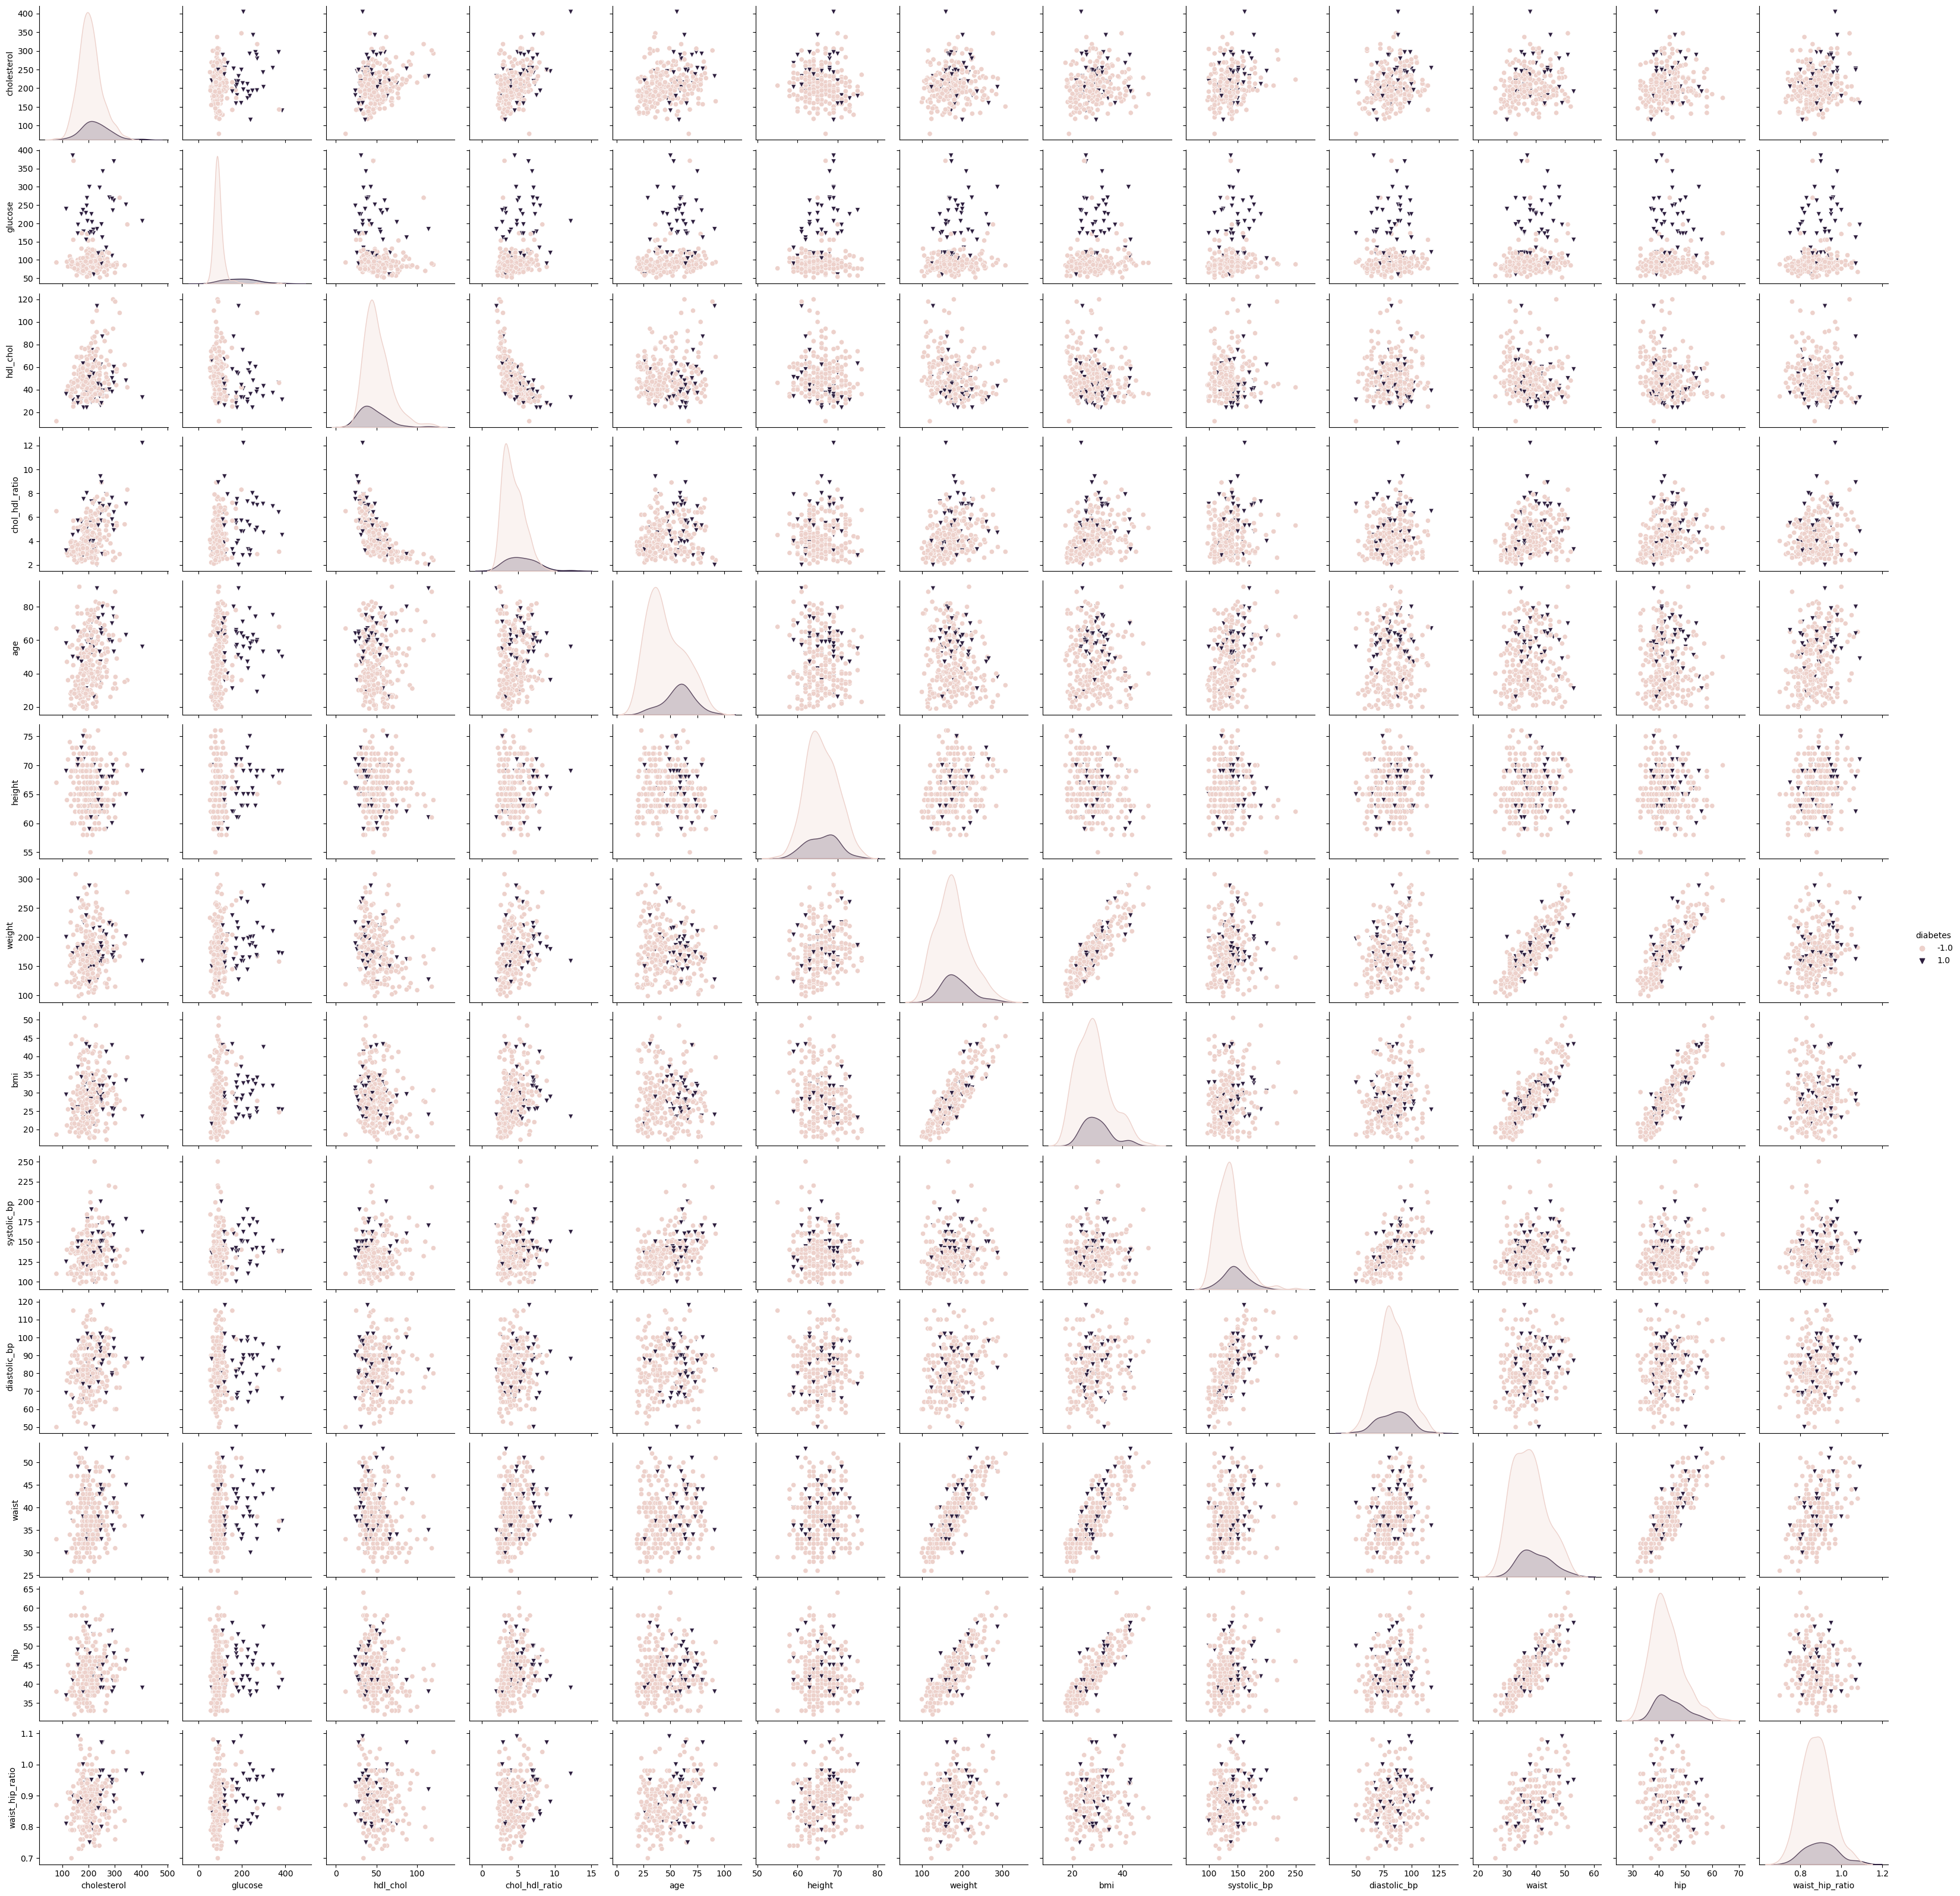

In [163]:
# create a pairplot of each feature of our training set, highlighting the diabetic from non-diabetic.
sns.pairplot(diabetes_data_1, hue="diabetes", markers=["o", "v"])

From this pairplot we notice that our plots involving glucose seem to show some separation of our diabetic and non-diabetic labels. Let us take a closer look.

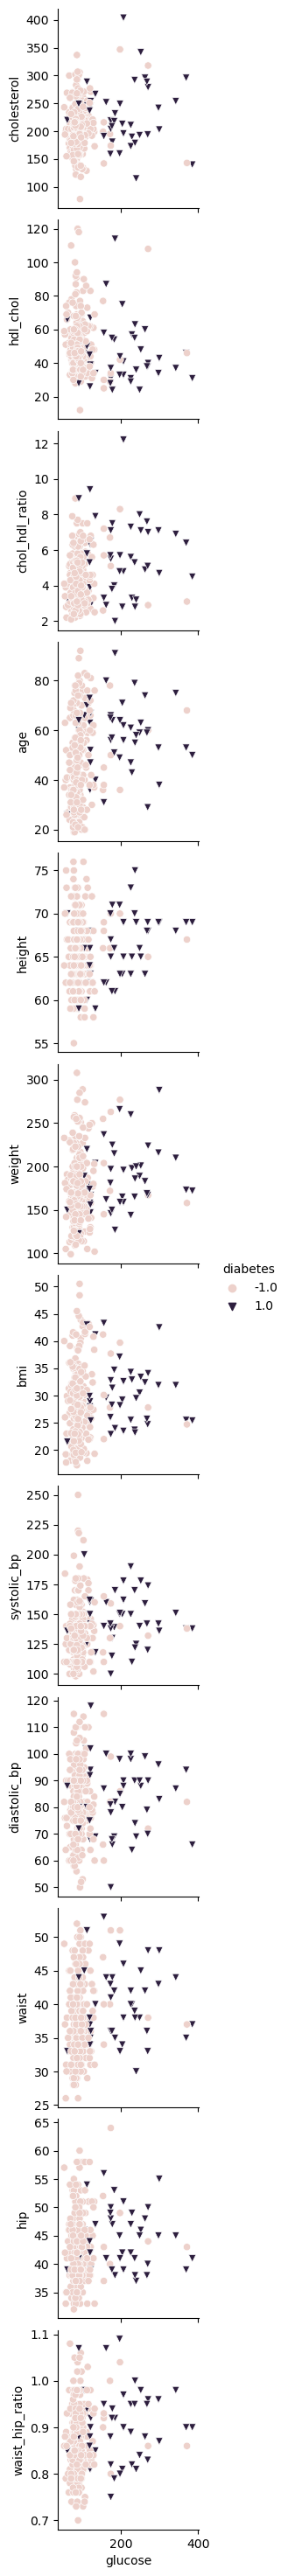

In [164]:
# display only the glucose column
sns.pairplot(diabetes_data_1, hue="diabetes", markers=["o", "v"], x_vars=["glucose"], y_vars=[label for label in diabetes_data_1.columns.values if label not in ["diabetes", "glucose"]])

It appears that we can indeed separate our diabetic and non-diabetic labels pretty well with a linear hyper-plane perpendicular or very close to perpendicular to the glucose axis; we can confirm whether this is how our our linaer SVM hyperplane splits the data by inspecting the optimal weights $\boldsymbol w$ trained earlier.

In [165]:
# print weights
print(f"weights for linear SVM: {w_optimal}")
# print feature labels
print(f"feature labels: {X_train_diabetes.columns.values}")

weights for linear SVM: [-0.03054183  1.09535723  0.11589117  0.19381967  0.03965552 -0.06509077
 -0.0662618   0.03374412  0.0353474   0.05350558  0.07860304 -0.02007792
  0.04046594 -1.112     ]
feature labels: ['cholesterol' 'glucose' 'hdl_chol' 'chol_hdl_ratio' 'age' 'height'
 'weight' 'bmi' 'systolic_bp' 'diastolic_bp' 'waist' 'hip'
 'waist_hip_ratio']


Indeed, the second entry of our weights has the largest magnitude, which corresponds to glucose, confirming our hypothesis.

In order to tune our kernel SVM further however, we should perform a grid search with cross-validation across the $\lambda$ and $\sigma$ hyper-parameters, since we only trained for fixed $\lambda = 10$ and $\sigma$ taking 4 values; these 4 pairs of hyper-parameters are unlikely to be the optimal to solve our classification problem.

We could also optimise over different sigmoid kernels, as the generic form of the sigmoid kernel has an arbitrary constant where we have a 1. Furthermore, we could even try and use different kernels all together, such as a Gaussian radial basis function, as different kernels allow our hyper-planes to take different shapes and some could work better than others.